# Tensorflow Object Detection API and AWS Sagemaker

In this notebook, you will train and evaluate different models using the [Tensorflow Object Detection API](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/) and [AWS Sagemaker](https://aws.amazon.com/sagemaker/). 

If you ever feel stuck, you can refer to this [tutorial](https://aws.amazon.com/blogs/machine-learning/training-and-deploying-models-using-tensorflow-2-with-the-object-detection-api-on-amazon-sagemaker/).

## Dataset

We are using the [Waymo Open Dataset](https://waymo.com/open/) for this project. The dataset has already been exported using the tfrecords format. The files have been created following the format described [here](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#create-tensorflow-records). You can find data stored on [AWS S3](https://aws.amazon.com/s3/), AWS Object Storage. The images are saved with a resolution of 640x640.

In [1]:
%%capture
%pip install tensorflow_io sagemaker -U

In [2]:
import os
import sagemaker
from sagemaker.estimator import Estimator
from framework import CustomFramework

Save the IAM role in a variable called `role`. This would be useful when training the model.

In [3]:
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::725448147626:role/service-role/AmazonSageMaker-ExecutionRole-20230620T161976
arn:aws:iam::725448147626:role/service-role/AmazonSageMaker-ExecutionRole-20230620T161976


In [4]:
# The train and val paths below are public S3 buckets created by Udacity for this project
inputs = {'train': 's3://object-detection-project-31416/train/', 
        'val': 's3://object-detection-project-31416/val/'} 

# Insert path of a folder in your personal S3 bucket to store tensorboard logs.
tensorboard_s3_prefix = 's3://object-detection-project-31416/logs/'

## Container

To train the model, you will first need to build a [docker](https://www.docker.com/) container with all the dependencies required by the TF Object Detection API. The code below does the following:
* clone the Tensorflow models repository
* get the exporter and training scripts from the the repository
* build the docker image and push it 
* print the container name

In [5]:
#%%bash

# clone the repo and get the scripts
#git clone https://github.com/tensorflow/models.git docker/models

# get model_main and exporter_main files from TF2 Object Detection GitHub repository
#cp docker/models/research/object_detection/exporter_main_v2.py source_dir 
#cp docker/models/research/object_detection/model_main_tf2.py source_dir

In [6]:
# build and push the docker image. This code can be commented after being ran once.
# This will take around 10 mins.
image_name = 'tf2-object-detection'
#!sh ./docker/build_and_push.sh $image_name

To verify that the image was correctly pushed to the [Elastic Container Registry](https://aws.amazon.com/ecr/), you can look at it in the AWS webapp. For example, below you can see that three different images have been pushed to ECR. You should only see one, called `tf2-object-detection`.
![ECR Example](../data/example_ecr.png)


In [7]:
# display the container name
with open (os.path.join('docker', 'ecr_image_fullname.txt'), 'r') as f:
    container = f.readlines()[0][:-1]

print(container)

725448147626.dkr.ecr.us-west-1.amazonaws.com/tf2-object-detection:20230621153530
725448147626.dkr.ecr.us-west-1.amazonaws.com/tf2-object-detection:20230621153530


## Pre-trained model from model zoo

As often, we are not training from scratch and we will be using a pretrained model from the TF Object Detection model zoo. You can find pretrained checkpoints [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). Because your time is limited for this project, we recommend to only experiment with the following models:
* SSD MobileNet V2 FPNLite 640x640	
* SSD ResNet50 V1 FPN 640x640 (RetinaNet50)	
* Faster R-CNN ResNet50 V1 640x640	
* EfficientDet D1 640x640	
* Faster R-CNN ResNet152 V1 640x640	

In the code below, the EfficientDet D1 model is downloaded and extracted. This code should be ajusted if you were to experiment with other architectures.

In [8]:
%%bash
mkdir /tmp/checkpoint
mkdir source_dir/checkpoint_fasterrcnn
wget -O /tmp/fasterrcnn.tar.gz http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.tar.gz
tar -zxvf /tmp/fasterrcnn.tar.gz --strip-components 2 --directory source_dir/checkpoint_fasterrcnn faster_rcnn_resnet152_v1_640x640_coco17_tpu-8/checkpoint

--2023-06-22 15:37:49--  http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.tar.gz
--2023-06-22 15:37:49--  http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.46.240, 2607:f8b0:4005:811::2010
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.46.240, 2607:f8b0:4005:811::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.46.240|:80... connected.
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.46.240|:80... connected.
HTTP request sent, awaiting response... 200 OK
HTTP request sent, awaiting response... 200 OK
Length: 470656289 (449M) [application/x-tar]
Length: 470656289 (449M) [application/x-tar]
Saving to: ‘/tmp/fasterrcnn.tar.gz’
Saving to: ‘/tmp/fasterrcnn.tar.gz’


     0K .......... .......... .......... .......

  2500K .......... .......... .......... .......... ..........  0%  160M 12s
  2550K .......... .......... .......... .......... ..........  0%  318M 12s
  2600K .......... .......... .......... .......... ..........  0%  345M 12s
  2650K .......... .......... .......... .......... ..........  0%  338M 12s
  2700K .......... .......... .......... .......... ..........  0%  268M 12s
  2200K .......... .......... .......... .......... ..........  0%  298M 14s
  2250K .......... .......... .......... .......... ..........  0%  505M 13s
  2300K .......... .......... .......... .......... ..........  0%  524M 13s
  2350K .......... .......... .......... .......... ..........  0% 58.8M 13s
  2400K .......... .......... .......... .......... ..........  0%  245M 13s
  2450K .......... .......... .......... .......... ..........  0%  213M 13s
  2500K .......... .......... .......... .......... ..........  0%  160M 12s
  2550K .......... .......... .......... .......... ..........  0%  318M 12s

  5050K .......... .......... .......... .......... ..........  1%  191M 10s
  5100K .......... .......... .......... .......... ..........  1%  151M 10s
  5150K .......... .......... .......... .......... ..........  1%  244M 10s
  5000K .......... .......... .......... .......... ..........  1%  149M 10s
  5050K .......... .......... .......... .......... ..........  1%  191M 10s
  5100K .......... .......... .......... .......... ..........  1%  151M 10s
  5150K .......... .......... .......... .......... ..........  1%  244M 10s
  5200K .......... .......... .......... .......... ..........  1%  172M 10s
  5250K .......... .......... .......... .......... ..........  1%  200M 9s
  5300K .......... .......... .......... .......... ..........  1%  243M 9s
  5350K .......... .......... .......... .......... ..........  1%  388M 9s
  5400K .......... .......... .......... .......... ..........  1%  377M 9s
  5450K .......... .......... .......... .......... ..........  1%  393M 9s
  55

  7450K .......... .......... .......... .......... ..........  1%  358M 8s
  7500K .......... .......... .......... .......... ..........  1%  324M 8s
  7550K .......... .......... .......... .......... ..........  1%  381M 8s
  7600K .......... .......... .......... .......... ..........  1%  341M 8s
  7650K .......... .......... .......... .......... ..........  1%  341M 8s
  7700K .......... .......... .......... .......... ..........  1%  325M 8s
  7750K .......... .......... .......... .......... ..........  1%  322M 8s
  7800K .......... .......... .......... .......... ..........  1%  379M 7s
  7850K .......... .......... .......... .......... ..........  1%  328M 7s
  7900K .......... .......... .......... .......... ..........  1%  323M 7s
  7950K .......... .......... .......... .......... ..........  1%  378M 7s
  8000K .......... .......... .......... .......... ..........  1%  339M 7s
  8050K .......... .......... .......... .......... ..........  1%  352M 7s
  8100K ....

 10300K .......... .......... .......... .......... ..........  2%  207M 14s
 10350K .......... .......... .......... .......... ..........  2%  285M 14s
 10400K .......... .......... .......... .......... ..........  2%  217M 14s
 10450K .......... .......... .......... .......... ..........  2%  208M 14s
 10500K .......... .......... .......... .......... ..........  2%  234M 14s
 10550K .......... .......... .......... .......... ..........  2%  225M 14s
 10600K .......... .......... .......... .......... ..........  2%  279M 14s
 10650K .......... .......... .......... .......... ..........  2%  279M 14s
 10700K .......... .......... .......... .......... ..........  2%  310M 14s
 10750K .......... .......... .......... .......... ..........  2%  361M 14s
 10800K .......... .......... .......... .......... ..........  2%  308M 14s
 10850K .......... .......... .......... .......... ..........  2%  285M 14s
 10900K .......... .......... .......... .......... ..........  2%  231M 13s

 13050K .......... .......... .......... .......... ..........  2%  266M 12s
 13100K .......... .......... .......... .......... ..........  2%  309M 12s
 13150K .......... .......... .......... .......... ..........  2%  248M 12s
 13200K .......... .......... .......... .......... ..........  2%  236M 12s
 13250K .......... .......... .......... .......... ..........  2%  360M 12s
 13300K .......... .......... .......... .......... ..........  2%  205M 12s
 13350K .......... .......... .......... .......... ..........  2%  271M 12s
 13400K .......... .......... .......... .......... ..........  2%  243M 12s
 13450K .......... .......... .......... .......... ..........  2%  337M 12s
 13100K .......... .......... .......... .......... ..........  2%  309M 12s
 13150K .......... .......... .......... .......... ..........  2%  248M 12s
 13200K .......... .......... .......... .......... ..........  2%  236M 12s
 13250K .......... .......... .......... .......... ..........  2%  360M 12s

 15750K .......... .......... .......... .......... ..........  3%  372M 10s
 15800K .......... .......... .......... .......... ..........  3%  358M 10s
 15850K .......... .......... .......... .......... ..........  3%  350M 10s
 15900K .......... .......... .......... .......... ..........  3%  318M 10s
 15950K .......... .......... .......... .......... ..........  3%  372M 10s
 16000K .......... .......... .......... .......... ..........  3%  294M 10s
 16050K .......... .......... .......... .......... ..........  3%  335M 10s
 15750K .......... .......... .......... .......... ..........  3%  372M 10s
 15800K .......... .......... .......... .......... ..........  3%  358M 10s
 15850K .......... .......... .......... .......... ..........  3%  350M 10s
 15900K .......... .......... .......... .......... ..........  3%  318M 10s
 15950K .......... .......... .......... .......... ..........  3%  372M 10s
 16000K .......... .......... .......... .......... ..........  3%  294M 10s

 18500K .......... .......... .......... .......... ..........  4%  199M 12s
 18550K .......... .......... .......... .......... ..........  4%  228M 12s
 18600K .......... .......... .......... .......... ..........  4%  257M 11s
 18650K .......... .......... .......... .......... ..........  4%  373M 11s
 18700K .......... .......... .......... .......... ..........  4%  245M 11s
 18350K .......... .......... .......... .......... ..........  4%  240M 12s
 18400K .......... .......... .......... .......... ..........  4%  249M 12s
 18450K .......... .......... .......... .......... ..........  4% 26.2M 12s
 18500K .......... .......... .......... .......... ..........  4%  199M 12s
 18550K .......... .......... .......... .......... ..........  4%  228M 12s
 18600K .......... .......... .......... .......... ..........  4%  257M 11s
 18650K .......... .......... .......... .......... ..........  4%  373M 11s
 18700K .......... .......... .......... .......... ..........  4%  245M 11s

 20850K .......... .......... .......... .......... ..........  4%  217M 11s
 20900K .......... .......... .......... .......... ..........  4%  185M 11s
 20950K .......... .......... .......... .......... ..........  4%  212M 11s
 21000K .......... .......... .......... .......... ..........  4%  290M 11s
 21050K .......... .......... .......... .......... ..........  4%  209M 11s
 21100K .......... .......... .......... .......... ..........  4%  192M 11s
 21150K .......... .......... .......... .......... ..........  4%  218M 10s
 21200K .......... .......... .......... .......... ..........  4%  232M 10s
 21250K .......... .......... .......... .......... ..........  4%  235M 10s
 21300K .......... .......... .......... .......... ..........  4%  218M 10s
 21350K .......... .......... .......... .......... ..........  4%  269M 10s
 21400K .......... .......... .......... .......... ..........  4%  191M 10s
 21450K .......... .......... .......... .......... ..........  4%  250M 10s

 23700K .......... .......... .......... .......... ..........  5%  321M 10s
 23750K .......... .......... .......... .......... ..........  5%  374M 10s
 23800K .......... .......... .......... .......... ..........  5%  328M 10s
 23850K .......... .......... .......... .......... ..........  5%  381M 10s
 23900K .......... .......... .......... .......... ..........  5%  328M 10s
 23950K .......... .......... .......... .......... ..........  5% 7.99M 10s
 24000K .......... .......... .......... .......... ..........  5%  360M 10s
 24050K .......... .......... .......... .......... ..........  5%  369M 10s
 24100K .......... .......... .......... .......... ..........  5%  317M 10s
 24150K .......... .......... .......... .......... ..........  5%  334M 10s
 24200K .......... .......... .......... .......... ..........  5%  334M 10s
 24250K .......... .......... .......... .......... ..........  5%  344M 9s
 24300K .......... .......... .......... .......... ..........  5%  295M 9s
 

 26650K .......... .......... .......... .......... ..........  5%  174M 11s
 26700K .......... .......... .......... .......... ..........  5%  174M 11s
 26250K .......... .......... .......... .......... ..........  5%  406M 11s
 26300K .......... .......... .......... .......... ..........  5%  351M 11s
 26350K .......... .......... .......... .......... ..........  5%  340M 11s
 26400K .......... .......... .......... .......... ..........  5% 28.4M 11s
 26450K .......... .......... .......... .......... ..........  5%  245M 11s
 26500K .......... .......... .......... .......... ..........  5%  284M 11s
 26550K .......... .......... .......... .......... ..........  5%  218M 11s
 26600K .......... .......... .......... .......... ..........  5%  199M 11s
 26650K .......... .......... .......... .......... ..........  5%  174M 11s
 26700K .......... .......... .......... .......... ..........  5%  174M 11s
 26750K .......... .......... .......... .......... ..........  5%  267M 11s

 29000K .......... .......... .......... .......... ..........  6%  241M 10s
 29050K .......... .......... .......... .......... ..........  6%  195M 10s
 29100K .......... .......... .......... .......... ..........  6%  182M 10s
 29150K .......... .......... .......... .......... ..........  6%  160M 10s
 29200K .......... .......... .......... .......... ..........  6%  149M 10s
 29250K .......... .......... .......... .......... ..........  6% 11.7M 10s
 29300K .......... .......... .......... .......... ..........  6%  365M 10s
 29350K .......... .......... .......... .......... ..........  6%  282M 10s
 29400K .......... .......... .......... .......... ..........  6%  209M 10s
 29450K .......... .......... .......... .......... ..........  6%  319M 10s
 29500K .......... .......... .......... .......... ..........  6%  232M 10s
 29550K .......... .......... .......... .......... ..........  6%  368M 10s
 29600K .......... .......... .......... .......... ..........  6%  365M 10s

 31600K .......... .......... .......... .......... ..........  6%  377M 10s
 31650K .......... .......... .......... .......... ..........  6%  292M 10s
 31700K .......... .......... .......... .......... ..........  6%  367M 10s
 31750K .......... .......... .......... .......... ..........  6%  380M 10s
 31800K .......... .......... .......... .......... ..........  6%  371M 10s
 31850K .......... .......... .......... .......... ..........  6%  280M 10s
 31900K .......... .......... .......... .......... ..........  6%  371M 9s
 31950K .......... .......... .......... .......... ..........  6%  322M 9s
 32000K .......... .......... .......... .......... ..........  6%  371M 9s
 32050K .......... .......... .......... .......... ..........  6%  322M 9s
 32100K .......... .......... .......... .......... ..........  6%  376M 9s
 32150K .......... .......... .......... .......... ..........  7%  295M 9s
 32200K .......... .......... .......... .......... ..........  7%  353M 9s
 32250

 34700K .......... .......... .......... .......... ..........  7%  393M 10s
 34750K .......... .......... .......... .......... ..........  7% 14.1M 10s
 34800K .......... .......... .......... .......... ..........  7%  230M 10s
 34250K .......... .......... .......... .......... ..........  7%  383M 10s
 34300K .......... .......... .......... .......... ..........  7%  395M 10s
 34350K .......... .......... .......... .......... ..........  7%  341M 10s
 34400K .......... .......... .......... .......... ..........  7%  259M 10s
 34450K .......... .......... .......... .......... ..........  7%  278M 10s
 34500K .......... .......... .......... .......... ..........  7%  220M 10s
 34550K .......... .......... .......... .......... ..........  7%  195M 10s
 34600K .......... .......... .......... .......... ..........  7%  371M 10s
 34650K .......... .......... .......... .......... ..........  7%  378M 10s
 34700K .......... .......... .......... .......... ..........  7%  393M 10s

 37200K .......... .......... .......... .......... ..........  8%  291M 10s
 37250K .......... .......... .......... .......... ..........  8%  360M 10s
 37300K .......... .......... .......... .......... ..........  8%  284M 10s
 37350K .......... .......... .......... .......... ..........  8%  319M 10s
 37400K .......... .......... .......... .......... ..........  8%  312M 10s
 37450K .......... .......... .......... .......... ..........  8%  368M 10s
 37500K .......... .......... .......... .......... ..........  8%  176M 10s
 37100K .......... .......... .......... .......... ..........  8%  185M 10s
 37150K .......... .......... .......... .......... ..........  8%  314M 10s
 37200K .......... .......... .......... .......... ..........  8%  291M 10s
 37250K .......... .......... .......... .......... ..........  8%  360M 10s
 37300K .......... .......... .......... .......... ..........  8%  284M 10s
 37350K .......... .......... .......... .......... ..........  8%  319M 10s

 39900K .......... .......... .......... .......... ..........  8%  367M 9s
 39950K .......... .......... .......... .......... ..........  8%  293M 9s
 40000K .......... .......... .......... .......... ..........  8% 7.72M 9s
 40050K .......... .......... .......... .......... ..........  8%  292M 9s
 39800K .......... .......... .......... .......... ..........  8%  381M 9s
 39850K .......... .......... .......... .......... ..........  8%  379M 9s
 39900K .......... .......... .......... .......... ..........  8%  367M 9s
 39950K .......... .......... .......... .......... ..........  8%  293M 9s
 40000K .......... .......... .......... .......... ..........  8% 7.72M 9s
 40050K .......... .......... .......... .......... ..........  8%  292M 9s
 40100K .......... .......... .......... .......... ..........  8%  195M 9s
 40150K .......... .......... .......... .......... ..........  8%  277M 9s
 40200K .......... .......... .......... .......... ..........  8% 41.2M 9s
 40250K ....

 42750K .......... .......... .......... .......... ..........  9%  388M 9s
 42350K .......... .......... .......... .......... ..........  9%  378M 9s
 42400K .......... .......... .......... .......... ..........  9%  379M 9s
 42450K .......... .......... .......... .......... ..........  9%  378M 9s
 42500K .......... .......... .......... .......... ..........  9%  328M 9s
 42550K .......... .......... .......... .......... ..........  9%  395M 9s
 42600K .......... .......... .......... .......... ..........  9%  377M 9s
 42650K .......... .......... .......... .......... ..........  9%  393M 9s
 42700K .......... .......... .......... .......... ..........  9%  316M 9s
 42750K .......... .......... .......... .......... ..........  9%  388M 9s
 42800K .......... .......... .......... .......... ..........  9%  391M 9s
 42850K .......... .......... .......... .......... ..........  9% 27.7M 9s
 42900K .......... .......... .......... .......... ..........  9%  334M 9s
 42950K ....

 45150K .......... .......... .......... .......... ..........  9%  386M 9s
 45200K .......... .......... .......... .......... ..........  9%  350M 9s
 45250K .......... .......... .......... .......... ..........  9%  402M 9s
 45300K .......... .......... .......... .......... ..........  9%  401M 9s
 45350K .......... .......... .......... .......... ..........  9%  268M 9s
 45400K .......... .......... .......... .......... ..........  9%  166M 9s
 45450K .......... .......... .......... .......... ..........  9%  329M 9s
 45500K .......... .......... .......... .......... ..........  9%  206M 9s
 45550K .......... .......... .......... .......... ..........  9% 7.15M 9s
 45600K .......... .......... .......... .......... ..........  9%  319M 9s
 45650K .......... .......... .......... .......... ..........  9%  256M 9s
 45700K .......... .......... .......... .......... ..........  9%  301M 9s
 45750K .......... .......... .......... .......... ..........  9%  213M 9s
 45350K ....

 47850K .......... .......... .......... .......... .......... 10%  358M 9s
 47900K .......... .......... .......... .......... .......... 10%  397M 9s
 47950K .......... .......... .......... .......... .......... 10%  363M 9s
 48000K .......... .......... .......... .......... .......... 10%  312M 9s
 48050K .......... .......... .......... .......... .......... 10%  398M 9s
 48100K .......... .......... .......... .......... .......... 10% 7.56M 9s
 48150K .......... .......... .......... .......... .......... 10%  371M 9s
 48050K .......... .......... .......... .......... .......... 10%  398M 9s
 48100K .......... .......... .......... .......... .......... 10% 7.56M 9s
 48150K .......... .......... .......... .......... .......... 10%  371M 9s
 48200K .......... .......... .......... .......... .......... 10%  328M 9s
 48250K .......... .......... .......... .......... .......... 10%  354M 9s
 48300K .......... .......... .......... .......... .......... 10%  387M 9s
 48350K ....

 50850K .......... .......... .......... .......... .......... 11%  204M 9s
 50900K .......... .......... .......... .......... .......... 11%  245M 9s
 50950K .......... .......... .......... .......... .......... 11%  333M 9s
 51000K .......... .......... .......... .......... .......... 11%  393M 9s
 50450K .......... .......... .......... .......... .......... 10%  326M 9s
 50500K .......... .......... .......... .......... .......... 10%  385M 9s
 50550K .......... .......... .......... .......... .......... 11%  335M 9s
 50600K .......... .......... .......... .......... .......... 11%  391M 9s
 50650K .......... .......... .......... .......... .......... 11%  298M 9s
 50700K .......... .......... .......... .......... .......... 11%  299M 9s
 50750K .......... .......... .......... .......... .......... 11%  237M 9s
 50800K .......... .......... .......... .......... .......... 11%  301M 9s
 50850K .......... .......... .......... .......... .......... 11%  204M 9s
 50900K ....

 53400K .......... .......... .......... .......... .......... 11%  377M 9s
 53300K .......... .......... .......... .......... .......... 11%  373M 9s
 53350K .......... .......... .......... .......... .......... 11%  328M 9s
 53400K .......... .......... .......... .......... .......... 11%  377M 9s
 53450K .......... .......... .......... .......... .......... 11%  351M 9s
 53500K .......... .......... .......... .......... .......... 11%  358M 9s
 53550K .......... .......... .......... .......... .......... 11%  269M 9s
 53600K .......... .......... .......... .......... .......... 11% 8.81M 9s
 53650K .......... .......... .......... .......... .......... 11%  241M 9s
 53700K .......... .......... .......... .......... .......... 11%  273M 9s
 53750K .......... .......... .......... .......... .......... 11%  164M 9s
 53800K .......... .......... .......... .......... .......... 11%  215M 9s
 53850K .......... .......... .......... .......... .......... 11%  367M 9s
 53900K ....

 56200K .......... .......... .......... .......... .......... 12%  326M 8s
 55900K .......... .......... .......... .......... .......... 12%  378M 8s
 55950K .......... .......... .......... .......... .......... 12%  288M 8s
 56000K .......... .......... .......... .......... .......... 12%  349M 8s
 56050K .......... .......... .......... .......... .......... 12%  322M 8s
 56100K .......... .......... .......... .......... .......... 12%  337M 8s
 56150K .......... .......... .......... .......... .......... 12%  326M 8s
 56200K .......... .......... .......... .......... .......... 12%  326M 8s
 56250K .......... .......... .......... .......... .......... 12%  350M 8s
 56250K .......... .......... .......... .......... .......... 12%  350M 8s
 56300K .......... .......... .......... .......... .......... 12%  373M 8s
 56350K .......... .......... .......... .......... .......... 12%  293M 8s
 56400K .......... .......... .......... .......... .......... 12%  346M 8s
 56450K ....

 58700K .......... .......... .......... .......... .......... 12%  206M 8s
 58750K .......... .......... .......... .......... .......... 12%  252M 8s
 58800K .......... .......... .......... .......... .......... 12%  222M 8s
 58850K .......... .......... .......... .......... .......... 12%  210M 8s
 58900K .......... .......... .......... .......... .......... 12%  364M 8s
 58950K .......... .......... .......... .......... .......... 12%  140M 8s
 59000K .......... .......... .......... .......... .......... 12%  271M 8s
 59050K .......... .......... .......... .......... .......... 12%  296M 8s
 59100K .......... .......... .......... .......... .......... 12%  322M 8s
 59150K .......... .......... .......... .......... .......... 12% 5.88M 8s
 59200K .......... .......... .......... .......... .......... 12%  265M 8s
 58800K .......... .......... .......... .......... .......... 12%  222M 8s
 58850K .......... .......... .......... .......... .......... 12%  210M 8s
 58900K ....

 61450K .......... .......... .......... .......... .......... 13%  339M 8s
 61450K .......... .......... .......... .......... .......... 13%  339M 8s
 61500K .......... .......... .......... .......... .......... 13%  298M 8s
 61550K .......... .......... .......... .......... .......... 13%  327M 8s
 61600K .......... .......... .......... .......... .......... 13%  286M 8s
 61650K .......... .......... .......... .......... .......... 13%  310M 8s
 61700K .......... .......... .......... .......... .......... 13%  278M 8s
 61750K .......... .......... .......... .......... .......... 13%  349M 8s
 61800K .......... .......... .......... .......... .......... 13%  257M 8s
 61850K .......... .......... .......... .......... .......... 13%  287M 8s
 61500K .......... .......... .......... .......... .......... 13%  298M 8s
 61550K .......... .......... .......... .......... .......... 13%  327M 8s
 61600K .......... .......... .......... .......... .......... 13%  286M 8s
 61650K ....

 63950K .......... .......... .......... .......... .......... 13%  357M 8s
 64000K .......... .......... .......... .......... .......... 13%  293M 8s
 64050K .......... .......... .......... .......... .......... 13%  372M 8s
 64100K .......... .......... .......... .......... .......... 13%  371M 8s
 64150K .......... .......... .......... .......... .......... 13%  389M 8s
 64200K .......... .......... .......... .......... .......... 13%  252M 8s
 64250K .......... .......... .......... .......... .......... 13%  331M 8s
 64300K .......... .......... .......... .......... .......... 14%  390M 8s
 64350K .......... .......... .......... .......... .......... 14%  400M 8s
 64350K .......... .......... .......... .......... .......... 14%  400M 8s
 64400K .......... .......... .......... .......... .......... 14%  295M 8s
 64450K .......... .......... .......... .......... .......... 14%  323M 8s
 64500K .......... .......... .......... .......... .......... 14%  351M 8s
 64550K ....

 67050K .......... .......... .......... .......... .......... 14%  381M 8s
 67100K .......... .......... .......... .......... .......... 14% 16.7M 8s
 67150K .......... .......... .......... .......... .......... 14%  246M 8s
 67200K .......... .......... .......... .......... .......... 14%  147M 8s
 67250K .......... .......... .......... .......... .......... 14%  197M 8s
 66650K .......... .......... .......... .......... .......... 14%  223M 8s
 66700K .......... .......... .......... .......... .......... 14%  389M 8s
 66750K .......... .......... .......... .......... .......... 14%  387M 8s
 66800K .......... .......... .......... .......... .......... 14%  305M 8s
 66850K .......... .......... .......... .......... .......... 14%  372M 8s
 66900K .......... .......... .......... .......... .......... 14%  151M 8s
 66950K .......... .......... .......... .......... .......... 14%  170M 8s
 67000K .......... .......... .......... .......... .......... 14%  292M 8s
 67050K ....

 69500K .......... .......... .......... .......... .......... 15%  321M 8s
 69550K .......... .......... .......... .......... .......... 15%  232M 8s
 69600K .......... .......... .......... .......... .......... 15%  263M 8s
 69650K .......... .......... .......... .......... .......... 15%  238M 8s
 69700K .......... .......... .......... .......... .......... 15%  288M 8s
 69750K .......... .......... .......... .......... .......... 15%  328M 8s
 69800K .......... .......... .......... .......... .......... 15% 12.4M 8s
 69850K .......... .......... .......... .......... .......... 15%  246M 8s
 69900K .......... .......... .......... .......... .......... 15%  190M 8s
 69950K .......... .......... .......... .......... .......... 15%  222M 8s
 69600K .......... .......... .......... .......... .......... 15%  263M 8s
 69650K .......... .......... .......... .......... .......... 15%  238M 8s
 69700K .......... .......... .......... .......... .......... 15%  288M 8s
 69750K ....

 72200K .......... .......... .......... .......... .......... 15%  313M 8s
 72250K .......... .......... .......... .......... .......... 15%  295M 8s
 72300K .......... .......... .......... .......... .......... 15%  373M 8s
 72300K .......... .......... .......... .......... .......... 15%  373M 8s
 72350K .......... .......... .......... .......... .......... 15%  380M 8s
 72400K .......... .......... .......... .......... .......... 15%  387M 8s
 72450K .......... .......... .......... .......... .......... 15%  301M 8s
 72500K .......... .......... .......... .......... .......... 15%  390M 8s
 72550K .......... .......... .......... .......... .......... 15%  380M 8s
 72600K .......... .......... .......... .......... .......... 15%  325M 8s
 72650K .......... .......... .......... .......... .......... 15%  310M 8s
 72700K .......... .......... .......... .......... .......... 15%  327M 8s
 72750K .......... .......... .......... .......... .......... 15%  382M 8s
 72800K ....

 74700K .......... .......... .......... .......... .......... 16%  235M 8s
 74750K .......... .......... .......... .......... .......... 16%  394M 8s
 74800K .......... .......... .......... .......... .......... 16%  250M 8s
 74850K .......... .......... .......... .......... .......... 16%  244M 8s
 74900K .......... .......... .......... .......... .......... 16%  196M 8s
 74950K .......... .......... .......... .......... .......... 16%  253M 8s
 75000K .......... .......... .......... .......... .......... 16%  377M 8s
 75050K .......... .......... .......... .......... .......... 16%  266M 8s
 75100K .......... .......... .......... .......... .......... 16%  204M 8s
 75150K .......... .......... .......... .......... .......... 16%  373M 8s
 75200K .......... .......... .......... .......... .......... 16%  234M 8s
 75200K .......... .......... .......... .......... .......... 16%  234M 8s
 75250K .......... .......... .......... .......... .......... 16%  251M 8s
 75250K ....

 77700K .......... .......... .......... .......... .......... 16%  323M 8s
 77750K .......... .......... .......... .......... .......... 16%  344M 8s
 77800K .......... .......... .......... .......... .......... 16%  306M 8s
 77850K .......... .......... .......... .......... .......... 16%  309M 8s
 77900K .......... .......... .......... .......... .......... 16%  355M 8s
 77950K .......... .......... .......... .......... .......... 16%  313M 8s
 78000K .......... .......... .......... .......... .......... 16%  311M 8s
 78050K .......... .......... .......... .......... .......... 16%  349M 8s
 78100K .......... .......... .......... .......... .......... 17%  344M 8s
 78150K .......... .......... .......... .......... .......... 17%  317M 8s
 78200K .......... .......... .......... .......... .......... 17%  318M 8s
 77600K .......... .......... .......... .......... .......... 16%  304M 8s
 77650K .......... .......... .......... .......... .......... 16%  366M 8s
 77700K ....

 80150K .......... .......... .......... .......... .......... 17%  392M 7s
 80200K .......... .......... .......... .......... .......... 17%  314M 7s
 80250K .......... .......... .......... .......... .......... 17%  382M 7s
 80300K .......... .......... .......... .......... .......... 17%  396M 7s
 80350K .......... .......... .......... .......... .......... 17%  394M 7s
 80400K .......... .......... .......... .......... .......... 17%  278M 7s
 80450K .......... .......... .......... .......... .......... 17%  343M 7s
 80500K .......... .......... .......... .......... .......... 17%  394M 7s
 80550K .......... .......... .......... .......... .......... 17%  394M 7s
 80550K .......... .......... .......... .......... .......... 17%  394M 7s
 80600K .......... .......... .......... .......... .......... 17%  333M 7s
 80650K .......... .......... .......... .......... .......... 17%  355M 7s
 80700K .......... .......... .......... .......... .......... 17%  399M 7s
 80750K ....

 83250K .......... .......... .......... .......... .......... 18%  262M 8s
 83300K .......... .......... .......... .......... .......... 18%  327M 8s
 83350K .......... .......... .......... .......... .......... 18%  302M 7s
 83400K .......... .......... .......... .......... .......... 18%  311M 7s
 83450K .......... .......... .......... .......... .......... 18% 10.2M 8s
 82850K .......... .......... .......... .......... .......... 18%  315M 8s
 82900K .......... .......... .......... .......... .......... 18%  291M 8s
 82950K .......... .......... .......... .......... .......... 18%  310M 8s
 83000K .......... .......... .......... .......... .......... 18%  270M 8s
 83050K .......... .......... .......... .......... .......... 18%  263M 8s
 83100K .......... .......... .......... .......... .......... 18%  236M 8s
 83150K .......... .......... .......... .......... .......... 18%  303M 8s
 83200K .......... .......... .......... .......... .......... 18%  249M 8s
 83250K ....

 85950K .......... .......... .......... .......... .......... 18%  333M 7s
 86000K .......... .......... .......... .......... .......... 18%  321M 7s
 85550K .......... .......... .......... .......... .......... 18%  360M 7s
 85600K .......... .......... .......... .......... .......... 18%  274M 7s
 85650K .......... .......... .......... .......... .......... 18%  332M 7s
 85700K .......... .......... .......... .......... .......... 18%  363M 7s
 85750K .......... .......... .......... .......... .......... 18%  414M 7s
 85800K .......... .......... .......... .......... .......... 18%  329M 7s
 85850K .......... .......... .......... .......... .......... 18%  333M 7s
 85900K .......... .......... .......... .......... .......... 18%  313M 7s
 85950K .......... .......... .......... .......... .......... 18%  333M 7s
 86000K .......... .......... .......... .......... .......... 18%  321M 7s
 86050K .......... .......... .......... .......... .......... 18% 5.93M 7s
 86050K ....

 88600K .......... .......... .......... .......... .......... 19% 5.94M 7s
 88650K .......... .......... .......... .......... .......... 19%  339M 7s
 88300K .......... .......... .......... .......... .......... 19%  362M 7s
 88350K .......... .......... .......... .......... .......... 19%  358M 7s
 88400K .......... .......... .......... .......... .......... 19%  270M 7s
 88450K .......... .......... .......... .......... .......... 19%  341M 7s
 88500K .......... .......... .......... .......... .......... 19%  400M 7s
 88550K .......... .......... .......... .......... .......... 19%  396M 7s
 88600K .......... .......... .......... .......... .......... 19% 5.94M 7s
 88650K .......... .......... .......... .......... .......... 19%  339M 7s
 88700K .......... .......... .......... .......... .......... 19%  382M 7s
 88750K .......... .......... .......... .......... .......... 19%  351M 7s
 88800K .......... .......... .......... .......... .......... 19%  314M 7s
 88850K ....

 91000K .......... .......... .......... .......... .......... 19%  212M 7s
 91050K .......... .......... .......... .......... .......... 19%  183M 7s
 91100K .......... .......... .......... .......... .......... 19%  196M 7s
 91150K .......... .......... .......... .......... .......... 19%  138M 7s
 91200K .......... .......... .......... .......... .......... 19%  277M 7s
 91250K .......... .......... .......... .......... .......... 19%  164M 7s
 91300K .......... .......... .......... .......... .......... 19%  229M 7s
 91350K .......... .......... .......... .......... .......... 19%  158M 7s
 91400K .......... .......... .......... .......... .......... 19%  199M 7s
 91450K .......... .......... .......... .......... .......... 19%  149M 7s
 91500K .......... .......... .......... .......... .......... 19%  143M 7s
 91550K .......... .......... .......... .......... .......... 19%  202M 7s
 91600K .......... .......... .......... .......... .......... 19%  150M 7s
 91650K ....

 93750K .......... .......... .......... .......... .......... 20%  361M 7s
 93800K .......... .......... .......... .......... .......... 20%  285M 7s
 93850K .......... .......... .......... .......... .......... 20%  384M 7s
 93900K .......... .......... .......... .......... .......... 20%  382M 7s
 93950K .......... .......... .......... .......... .......... 20%  317M 7s
 94000K .......... .......... .......... .......... .......... 20%  229M 7s
 94050K .......... .......... .......... .......... .......... 20%  363M 7s
 94100K .......... .......... .......... .......... .......... 20%  381M 7s
 94150K .......... .......... .......... .......... .......... 20%  283M 7s
 94200K .......... .......... .......... .......... .......... 20%  272M 7s
 94250K .......... .......... .......... .......... .......... 20%  293M 7s
 93950K .......... .......... .......... .......... .......... 20%  317M 7s
 94000K .......... .......... .......... .......... .......... 20%  229M 7s
 94050K ....

 96400K .......... .......... .......... .......... .......... 20%  306M 7s
 96450K .......... .......... .......... .......... .......... 20%  374M 7s
 96500K .......... .......... .......... .......... .......... 21%  342M 7s
 96550K .......... .......... .......... .......... .......... 21%  368M 7s
 96600K .......... .......... .......... .......... .......... 21%  325M 7s
 96650K .......... .......... .......... .......... .......... 21%  312M 7s
 96700K .......... .......... .......... .......... .......... 21%  354M 7s
 96750K .......... .......... .......... .......... .......... 21%  353M 7s
 96700K .......... .......... .......... .......... .......... 21%  354M 7s
 96750K .......... .......... .......... .......... .......... 21%  353M 7s
 96800K .......... .......... .......... .......... .......... 21%  293M 7s
 96850K .......... .......... .......... .......... .......... 21%  383M 7s
 96900K .......... .......... .......... .......... .......... 21%  372M 7s
 96950K ....

 99300K .......... .......... .......... .......... .......... 21%  163M 7s
 99350K .......... .......... .......... .......... .......... 21%  143M 7s
 99400K .......... .......... .......... .......... .......... 21%  174M 7s
 99450K .......... .......... .......... .......... .......... 21% 74.2M 7s
 99500K .......... .......... .......... .......... .......... 21%  349M 7s
 99550K .......... .......... .......... .......... .......... 21%  214M 7s
 99600K .......... .......... .......... .......... .......... 21%  380M 7s
 99650K .......... .......... .......... .......... .......... 21%  398M 7s
 99700K .......... .......... .......... .......... .......... 21% 43.0M 7s
 99750K .......... .......... .......... .......... .......... 21%  196M 7s
 99800K .......... .......... .......... .......... .......... 21%  211M 7s
 99200K .......... .......... .......... .......... .......... 21%  169M 7s
 99250K .......... .......... .......... .......... .......... 21%  198M 7s
 99300K ....

101800K .......... .......... .......... .......... .......... 22%  374M 7s
101850K .......... .......... .......... .......... .......... 22%  376M 7s
101900K .......... .......... .......... .......... .......... 22%  381M 7s
101950K .......... .......... .......... .......... .......... 22%  327M 7s
102000K .......... .......... .......... .......... .......... 22%  243M 7s
102050K .......... .......... .......... .......... .......... 22%  305M 7s
102100K .......... .......... .......... .......... .......... 22%  252M 7s
102150K .......... .......... .......... .......... .......... 22%  210M 7s
102100K .......... .......... .......... .......... .......... 22%  252M 7s
102150K .......... .......... .......... .......... .......... 22%  210M 7s
102200K .......... .......... .......... .......... .......... 22% 9.52M 7s
102250K .......... .......... .......... .......... .......... 22% 77.8M 7s
102300K .......... .......... .......... .......... .......... 22%  352M 7s
102350K ....

104850K .......... .......... .......... .......... .......... 22%  375M 7s
104900K .......... .......... .......... .......... .......... 22%  385M 7s
104950K .......... .......... .......... .......... .......... 22%  293M 7s
105000K .......... .......... .......... .......... .......... 22%  383M 7s
105050K .......... .......... .......... .......... .......... 22%  379M 7s
104450K .......... .......... .......... .......... .......... 22%  353M 7s
104500K .......... .......... .......... .......... .......... 22%  342M 7s
104550K .......... .......... .......... .......... .......... 22%  332M 7s
104600K .......... .......... .......... .......... .......... 22%  367M 7s
104650K .......... .......... .......... .......... .......... 22%  299M 7s
104700K .......... .......... .......... .......... .......... 22%  393M 7s
104750K .......... .......... .......... .......... .......... 22%  276M 7s
104800K .......... .......... .......... .......... .......... 22%  347M 7s
104850K ....

107500K .......... .......... .......... .......... .......... 23%  159M 7s
107550K .......... .......... .......... .......... .......... 23%  168M 7s
107200K .......... .......... .......... .......... .......... 23%  189M 7s
107250K .......... .......... .......... .......... .......... 23%  160M 7s
107300K .......... .......... .......... .......... .......... 23%  181M 7s
107350K .......... .......... .......... .......... .......... 23%  185M 7s
107400K .......... .......... .......... .......... .......... 23%  229M 7s
107450K .......... .......... .......... .......... .......... 23%  141M 7s
107500K .......... .......... .......... .......... .......... 23%  159M 7s
107550K .......... .......... .......... .......... .......... 23%  168M 7s
107600K .......... .......... .......... .......... .......... 23%  222M 7s
107650K .......... .......... .......... .......... .......... 23%  144M 7s
107600K .......... .......... .......... .......... .......... 23%  222M 7s
107650K ....

110000K .......... .......... .......... .......... .......... 23%  288M 7s
110100K .......... .......... .......... .......... .......... 23%  293M 7s
110150K .......... .......... .......... .......... .......... 23%  326M 7s
110200K .......... .......... .......... .......... .......... 23%  291M 7s
110250K .......... .......... .......... .......... .......... 23%  237M 7s
110300K .......... .......... .......... .......... .......... 24%  317M 7s
110350K .......... .......... .......... .......... .......... 24%  301M 7s
110400K .......... .......... .......... .......... .......... 24%  215M 7s
110450K .......... .......... .......... .......... .......... 24%  219M 7s
110500K .......... .......... .......... .......... .......... 24%  332M 7s
110550K .......... .......... .......... .......... .......... 24%  268M 7s
110050K .......... .......... .......... .......... .......... 23%  304M 7s
110100K .......... .......... .......... .......... .......... 23%  293M 7s
110150K ....

112800K .......... .......... .......... .......... .......... 24%  358M 7s
112850K .......... .......... .......... .......... .......... 24%  287M 7s
112900K .......... .......... .......... .......... .......... 24%  380M 7s
112950K .......... .......... .......... .......... .......... 24%  378M 7s
113000K .......... .......... .......... .......... .......... 24%  345M 7s
113050K .......... .......... .......... .......... .......... 24%  260M 7s
113100K .......... .......... .......... .......... .......... 24%  369M 7s
113150K .......... .......... .......... .......... .......... 24%  333M 7s
113200K .......... .......... .......... .......... .......... 24%  382M 7s
113250K .......... .......... .......... .......... .......... 24%  307M 7s
112700K .......... .......... .......... .......... .......... 24%  383M 7s
113300K .......... .......... .......... .......... .......... 24%  381M 7s
112750K .......... .......... .......... .......... .......... 24%  374M 7s
112800K ....

115300K .......... .......... .......... .......... .......... 25%  168M 7s
115350K .......... .......... .......... .......... .......... 25%  179M 7s
115400K .......... .......... .......... .......... .......... 25%  131M 7s
115450K .......... .......... .......... .......... .......... 25%  181M 7s
115500K .......... .......... .......... .......... .......... 25%  135M 7s
115550K .......... .......... .......... .......... .......... 25%  215M 7s
115600K .......... .......... .......... .......... .......... 25%  172M 7s
115600K .......... .......... .......... .......... .......... 25%  172M 7s
115650K .......... .......... .......... .......... .......... 25%  180M 7s
115650K .......... .......... .......... .......... .......... 25%  180M 7s
115700K .......... .......... .......... .......... .......... 25%  147M 7s
115750K .......... .......... .......... .......... .......... 25%  161M 7s
115800K .......... .......... .......... .......... .......... 25%  135M 7s
115850K ....

118350K .......... .......... .......... .......... .......... 25% 23.3M 7s
118400K .......... .......... .......... .......... .......... 25%  255M 7s
118450K .......... .......... .......... .......... .......... 25%  210M 7s
118500K .......... .......... .......... .......... .......... 25%  200M 7s
117950K .......... .......... .......... .......... .......... 25% 6.93M 7s
118000K .......... .......... .......... .......... .......... 25%  198M 7s
118050K .......... .......... .......... .......... .......... 25%  353M 7s
118100K .......... .......... .......... .......... .......... 25%  322M 7s
118150K .......... .......... .......... .......... .......... 25%  363M 7s
118200K .......... .......... .......... .......... .......... 25%  372M 7s
118250K .......... .......... .......... .......... .......... 25%  380M 7s
118300K .......... .......... .......... .......... .......... 25%  318M 7s
118350K .......... .......... .......... .......... .......... 25% 23.3M 7s
118400K ....

121050K .......... .......... .......... .......... .......... 26%  364M 7s
121100K .......... .......... .......... .......... .......... 26%  325M 7s
121150K .......... .......... .......... .......... .......... 26%  383M 7s
121200K .......... .......... .......... .......... .......... 26%  357M 7s
120650K .......... .......... .......... .......... .......... 26%  231M 7s
121250K .......... .......... .......... .......... .......... 26%  339M 7s
120700K .......... .......... .......... .......... .......... 26%  200M 7s
120750K .......... .......... .......... .......... .......... 26%  283M 7s
120800K .......... .......... .......... .......... .......... 26%  294M 7s
120850K .......... .......... .......... .......... .......... 26%  287M 7s
120900K .......... .......... .......... .......... .......... 26% 11.3M 7s
120950K .......... .......... .......... .......... .......... 26%  299M 7s
121000K .......... .......... .......... .......... .......... 26%  378M 7s
121050K ....

123550K .......... .......... .......... .......... .......... 26%  391M 6s
123600K .......... .......... .......... .......... .......... 26%  405M 6s
123650K .......... .......... .......... .......... .......... 26%  283M 6s
123700K .......... .......... .......... .......... .......... 26%  300M 6s
123750K .......... .......... .......... .......... .......... 26%  386M 6s
123800K .......... .......... .......... .......... .......... 26%  382M 6s
123850K .......... .......... .......... .......... .......... 26%  269M 6s
123900K .......... .......... .......... .......... .......... 26%  219M 6s
123950K .......... .......... .......... .......... .......... 26%  201M 6s
124000K .......... .......... .......... .......... .......... 26%  143M 6s
124050K .......... .......... .......... .......... .......... 27%  298M 6s
124100K .......... .......... .......... .......... .......... 27%  178M 6s
123550K .......... .......... .......... .......... .......... 26%  391M 6s
123600K ....

126100K .......... .......... .......... .......... .......... 27%  176M 6s
126150K .......... .......... .......... .......... .......... 27%  220M 6s
126200K .......... .......... .......... .......... .......... 27%  240M 6s
126250K .......... .......... .......... .......... .......... 27%  171M 6s
126300K .......... .......... .......... .......... .......... 27%  201M 6s
126350K .......... .......... .......... .......... .......... 27%  200M 6s
126400K .......... .......... .......... .......... .......... 27%  249M 6s
126400K .......... .......... .......... .......... .......... 27%  249M 6s
126450K .......... .......... .......... .......... .......... 27%  230M 6s
126450K .......... .......... .......... .......... .......... 27%  230M 6s
126500K .......... .......... .......... .......... .......... 27%  186M 6s
126550K .......... .......... .......... .......... .......... 27% 6.17M 6s
126600K .......... .......... .......... .......... .......... 27%  352M 6s
126650K ....

129150K .......... .......... .......... .......... .......... 28%  362M 6s
129200K .......... .......... .......... .......... .......... 28%  343M 6s
129250K .......... .......... .......... .......... .......... 28%  366M 6s
129300K .......... .......... .......... .......... .......... 28%  331M 6s
128750K .......... .......... .......... .......... .......... 28% 26.2M 6s
129350K .......... .......... .......... .......... .......... 28%  345M 6s
128800K .......... .......... .......... .......... .......... 28%  321M 6s
128850K .......... .......... .......... .......... .......... 28%  368M 6s
128900K .......... .......... .......... .......... .......... 28%  300M 6s
128950K .......... .......... .......... .......... .......... 28%  368M 6s
129000K .......... .......... .......... .......... .......... 28%  376M 6s
129050K .......... .......... .......... .......... .......... 28%  318M 6s
129100K .......... .......... .......... .......... .......... 28%  299M 6s
129150K ....

131650K .......... .......... .......... .......... .......... 28%  291M 6s
131650K .......... .......... .......... .......... .......... 28%  291M 6s
131700K .......... .......... .......... .......... .......... 28%  299M 6s
131700K .......... .......... .......... .......... .......... 28%  299M 6s
131750K .......... .......... .......... .......... .......... 28%  250M 6s
131800K .......... .......... .......... .......... .......... 28%  298M 6s
131850K .......... .......... .......... .......... .......... 28%  315M 6s
131900K .......... .......... .......... .......... .......... 28%  196M 6s
131950K .......... .......... .......... .......... .......... 28%  266M 6s
132000K .......... .......... .......... .......... .......... 28%  303M 6s
132050K .......... .......... .......... .......... .......... 28%  308M 6s
132100K .......... .......... .......... .......... .......... 28%  171M 6s
132150K .......... .......... .......... .......... .......... 28%  297M 6s
132200K ....

134300K .......... .......... .......... .......... .......... 29%  193M 6s
134350K .......... .......... .......... .......... .......... 29% 68.5M 6s
134400K .......... .......... .......... .......... .......... 29%  304M 6s
134400K .......... .......... .......... .......... .......... 29%  304M 6s
134450K .......... .......... .......... .......... .......... 29%  227M 6s
134500K .......... .......... .......... .......... .......... 29%  313M 6s
134550K .......... .......... .......... .......... .......... 29%  310M 6s
134600K .......... .......... .......... .......... .......... 29% 33.6M 6s
134650K .......... .......... .......... .......... .......... 29%  213M 6s
134700K .......... .......... .......... .......... .......... 29%  240M 6s
134750K .......... .......... .......... .......... .......... 29%  281M 6s
134800K .......... .......... .......... .......... .......... 29%  231M 6s
134850K .......... .......... .......... .......... .......... 29%  274M 6s
134900K ....

137050K .......... .......... .......... .......... .......... 29%  304M 6s
137100K .......... .......... .......... .......... .......... 29%  376M 6s
137050K .......... .......... .......... .......... .......... 29%  304M 6s
137100K .......... .......... .......... .......... .......... 29%  376M 6s
137150K .......... .......... .......... .......... .......... 29%  364M 6s
137200K .......... .......... .......... .......... .......... 29%  344M 6s
137250K .......... .......... .......... .......... .......... 29%  325M 6s
137300K .......... .......... .......... .......... .......... 29%  378M 6s
137350K .......... .......... .......... .......... .......... 29%  346M 6s
137400K .......... .......... .......... .......... .......... 29%  380M 6s
137450K .......... .......... .......... .......... .......... 29%  323M 6s
137150K .......... .......... .......... .......... .......... 29%  364M 6s
137200K .......... .......... .......... .......... .......... 29%  344M 6s
137250K ....

139700K .......... .......... .......... .......... .......... 30%  170M 6s
139750K .......... .......... .......... .......... .......... 30%  245M 6s
139800K .......... .......... .......... .......... .......... 30%  260M 6s
139850K .......... .......... .......... .......... .......... 30%  381M 6s
139900K .......... .......... .......... .......... .......... 30%  211M 6s
139800K .......... .......... .......... .......... .......... 30%  260M 6s
139850K .......... .......... .......... .......... .......... 30%  381M 6s
139900K .......... .......... .......... .......... .......... 30%  211M 6s
139950K .......... .......... .......... .......... .......... 30%  267M 6s
140000K .......... .......... .......... .......... .......... 30%  247M 6s
140050K .......... .......... .......... .......... .......... 30%  340M 6s
140100K .......... .......... .......... .......... .......... 30%  238M 6s
140150K .......... .......... .......... .......... .......... 30%  237M 6s
140200K ....

142600K .......... .......... .......... .......... .......... 31%  302M 6s
142650K .......... .......... .......... .......... .......... 31%  195M 6s
142700K .......... .......... .......... .......... .......... 31%  238M 6s
142750K .......... .......... .......... .......... .......... 31%  263M 6s
142800K .......... .......... .......... .......... .......... 31%  304M 6s
142850K .......... .......... .......... .......... .......... 31%  227M 6s
142300K .......... .......... .......... .......... .......... 30%  318M 6s
142350K .......... .......... .......... .......... .......... 30%  258M 6s
142400K .......... .......... .......... .......... .......... 30%  315M 6s
142450K .......... .......... .......... .......... .......... 31%  260M 6s
142500K .......... .......... .......... .......... .......... 31%  243M 6s
142550K .......... .......... .......... .......... .......... 31%  280M 6s
142600K .......... .......... .......... .......... .......... 31%  302M 6s
142650K ....

145250K .......... .......... .......... .......... .......... 31%  329M 6s
145300K .......... .......... .......... .......... .......... 31%  320M 6s
145350K .......... .......... .......... .......... .......... 31%  382M 6s
145400K .......... .......... .......... .......... .......... 31%  376M 6s
145450K .......... .......... .......... .......... .......... 31%  308M 6s
145050K .......... .......... .......... .......... .......... 31%  323M 6s
145100K .......... .......... .......... .......... .......... 31%  311M 6s
145150K .......... .......... .......... .......... .......... 31%  333M 6s
145200K .......... .......... .......... .......... .......... 31%  340M 6s
145250K .......... .......... .......... .......... .......... 31%  329M 6s
145300K .......... .......... .......... .......... .......... 31%  320M 6s
145350K .......... .......... .......... .......... .......... 31%  382M 6s
145400K .......... .......... .......... .......... .......... 31%  376M 6s
145450K ....

147950K .......... .......... .......... .......... .......... 32%  177M 6s
148000K .......... .......... .......... .......... .......... 32%  137M 6s
147750K .......... .......... .......... .......... .......... 32%  119M 6s
147800K .......... .......... .......... .......... .......... 32%  246M 6s
147850K .......... .......... .......... .......... .......... 32%  111M 6s
147900K .......... .......... .......... .......... .......... 32%  224M 6s
147950K .......... .......... .......... .......... .......... 32%  177M 6s
148000K .......... .......... .......... .......... .......... 32%  137M 6s
148050K .......... .......... .......... .......... .......... 32%  200M 6s
148100K .......... .......... .......... .......... .......... 32%  156M 6s
148150K .......... .......... .......... .......... .......... 32%  152M 6s
148200K .......... .......... .......... .......... .......... 32%  189M 6s
148250K .......... .......... .......... .......... .......... 32%  255M 6s
148300K ....

150350K .......... .......... .......... .......... .......... 32%  247M 5s
150400K .......... .......... .......... .......... .......... 32%  311M 5s
150450K .......... .......... .......... .......... .......... 32%  296M 5s
150500K .......... .......... .......... .......... .......... 32%  282M 5s
150550K .......... .......... .......... .......... .......... 32%  261M 5s
150600K .......... .......... .......... .......... .......... 32%  318M 5s
150650K .......... .......... .......... .......... .......... 32%  288M 5s
150700K .......... .......... .......... .......... .......... 32%  360M 5s
150750K .......... .......... .......... .......... .......... 32%  324M 5s
150800K .......... .......... .......... .......... .......... 32%  348M 5s
150850K .......... .......... .......... .......... .......... 32%  314M 5s
150900K .......... .......... .......... .......... .......... 32%  332M 5s
150950K .......... .......... .......... .......... .......... 32%  283M 5s
151000K ....

153200K .......... .......... .......... .......... .......... 33%  370M 5s
153250K .......... .......... .......... .......... .......... 33%  370M 5s
153300K .......... .......... .......... .......... .......... 33%  368M 5s
153350K .......... .......... .......... .......... .......... 33%  306M 5s
153400K .......... .......... .......... .......... .......... 33%  363M 5s
153450K .......... .......... .......... .......... .......... 33%  332M 5s
153500K .......... .......... .......... .......... .......... 33%  359M 5s
153550K .......... .......... .......... .......... .......... 33%  323M 5s
153600K .......... .......... .......... .......... .......... 33%  358M 5s
153650K .......... .......... .......... .......... .......... 33%  351M 5s
153700K .......... .......... .......... .......... .......... 33%  375M 5s
153300K .......... .......... .......... .......... .......... 33%  368M 5s
153350K .......... .......... .......... .......... .......... 33%  306M 5s
153400K ....

155900K .......... .......... .......... .......... .......... 33%  347M 5s
155950K .......... .......... .......... .......... .......... 33%  276M 5s
156000K .......... .......... .......... .......... .......... 33%  287M 5s
156050K .......... .......... .......... .......... .......... 33%  361M 5s
156100K .......... .......... .......... .......... .......... 33%  301M 5s
156150K .......... .......... .......... .......... .......... 33%  309M 5s
156200K .......... .......... .......... .......... .......... 33%  331M 5s
156250K .......... .......... .......... .......... .......... 34%  334M 5s
156000K .......... .......... .......... .......... .......... 33%  287M 5s
156050K .......... .......... .......... .......... .......... 33%  361M 5s
156100K .......... .......... .......... .......... .......... 33%  301M 5s
156150K .......... .......... .......... .......... .......... 33%  309M 5s
156200K .......... .......... .......... .......... .......... 33%  331M 5s
156250K ....

158750K .......... .......... .......... .......... .......... 34%  296M 5s
158800K .......... .......... .......... .......... .......... 34%  345M 5s
158850K .......... .......... .......... .......... .......... 34%  326M 5s
158900K .......... .......... .......... .......... .......... 34%  323M 5s
158950K .......... .......... .......... .......... .......... 34%  279M 5s
158550K .......... .......... .......... .......... .......... 34%  253M 5s
158600K .......... .......... .......... .......... .......... 34%  301M 5s
158650K .......... .......... .......... .......... .......... 34%  293M 5s
158700K .......... .......... .......... .......... .......... 34%  316M 5s
158750K .......... .......... .......... .......... .......... 34%  296M 5s
158800K .......... .......... .......... .......... .......... 34%  345M 5s
158850K .......... .......... .......... .......... .......... 34%  326M 5s
158900K .......... .......... .......... .......... .......... 34%  323M 5s
158950K ....

161450K .......... .......... .......... .......... .......... 35%  376M 5s
161500K .......... .......... .......... .......... .......... 35%  294M 5s
161250K .......... .......... .......... .......... .......... 35%  296M 5s
161300K .......... .......... .......... .......... .......... 35%  358M 5s
161350K .......... .......... .......... .......... .......... 35%  300M 5s
161400K .......... .......... .......... .......... .......... 35%  335M 5s
161450K .......... .......... .......... .......... .......... 35%  376M 5s
161500K .......... .......... .......... .......... .......... 35%  294M 5s
161550K .......... .......... .......... .......... .......... 35%  288M 5s
161600K .......... .......... .......... .......... .......... 35%  369M 5s
161650K .......... .......... .......... .......... .......... 35%  273M 5s
161700K .......... .......... .......... .......... .......... 35%  359M 5s
161750K .......... .......... .......... .......... .......... 35%  327M 5s
161800K ....

163850K .......... .......... .......... .......... .......... 35% 88.1M 5s
163900K .......... .......... .......... .......... .......... 35%  245M 5s
163950K .......... .......... .......... .......... .......... 35%  129M 5s
164000K .......... .......... .......... .......... .......... 35%  104M 5s
164050K .......... .......... .......... .......... .......... 35%  127M 5s
164100K .......... .......... .......... .......... .......... 35%  234M 5s
164150K .......... .......... .......... .......... .......... 35%  137M 5s
164200K .......... .......... .......... .......... .......... 35%  312M 5s
164250K .......... .......... .......... .......... .......... 35%  312M 5s
164300K .......... .......... .......... .......... .......... 35%  270M 5s
164350K .......... .......... .......... .......... .......... 35%  288M 5s
164400K .......... .......... .......... .......... .......... 35%  229M 5s
164450K .......... .......... .......... .......... .......... 35%  178M 5s
164500K ....

166700K .......... .......... .......... .......... .......... 36%  354M 5s
166750K .......... .......... .......... .......... .......... 36%  287M 5s
166800K .......... .......... .......... .......... .......... 36%  343M 5s
166850K .......... .......... .......... .......... .......... 36%  329M 5s
166900K .......... .......... .......... .......... .......... 36%  389M 5s
166950K .......... .......... .......... .......... .......... 36%  278M 5s
167000K .......... .......... .......... .......... .......... 36%  295M 5s
167050K .......... .......... .......... .......... .......... 36%  306M 5s
167100K .......... .......... .......... .......... .......... 36%  338M 5s
167150K .......... .......... .......... .......... .......... 36%  300M 5s
167200K .......... .......... .......... .......... .......... 36%  344M 5s
166800K .......... .......... .......... .......... .......... 36%  343M 5s
166850K .......... .......... .......... .......... .......... 36%  329M 5s
166900K ....

169400K .......... .......... .......... .......... .......... 36%  358M 5s
169450K .......... .......... .......... .......... .......... 36%  323M 5s
169500K .......... .......... .......... .......... .......... 36%  352M 5s
169550K .......... .......... .......... .......... .......... 36%  289M 5s
169600K .......... .......... .......... .......... .......... 36%  367M 5s
169650K .......... .......... .......... .......... .......... 36%  331M 5s
169700K .......... .......... .......... .......... .......... 36%  199M 5s
169750K .......... .......... .......... .......... .......... 36%  319M 5s
169500K .......... .......... .......... .......... .......... 36%  352M 5s
169550K .......... .......... .......... .......... .......... 36%  289M 5s
169600K .......... .......... .......... .......... .......... 36%  367M 5s
169650K .......... .......... .......... .......... .......... 36%  331M 5s
169700K .......... .......... .......... .......... .......... 36%  199M 5s
169750K ....

172250K .......... .......... .......... .......... .......... 37% 45.1M 5s
172300K .......... .......... .......... .......... .......... 37%  168M 5s
172350K .......... .......... .......... .......... .......... 37%  160M 5s
172400K .......... .......... .......... .......... .......... 37%  371M 5s
172450K .......... .......... .......... .......... .......... 37%  321M 5s
172050K .......... .......... .......... .......... .......... 37%  162M 5s
172100K .......... .......... .......... .......... .......... 37%  173M 5s
172150K .......... .......... .......... .......... .......... 37%  183M 5s
172200K .......... .......... .......... .......... .......... 37% 53.3M 5s
172250K .......... .......... .......... .......... .......... 37% 45.1M 5s
172300K .......... .......... .......... .......... .......... 37%  168M 5s
172350K .......... .......... .......... .......... .......... 37%  160M 5s
172400K .......... .......... .......... .......... .......... 37%  371M 5s
172450K ....

174950K .......... .......... .......... .......... .......... 38%  306M 5s
175000K .......... .......... .......... .......... .......... 38%  255M 5s
174750K .......... .......... .......... .......... .......... 38%  370M 5s
174800K .......... .......... .......... .......... .......... 38%  320M 5s
174850K .......... .......... .......... .......... .......... 38%  347M 5s
174900K .......... .......... .......... .......... .......... 38%  306M 5s
174950K .......... .......... .......... .......... .......... 38%  306M 5s
175000K .......... .......... .......... .......... .......... 38%  255M 5s
175050K .......... .......... .......... .......... .......... 38%  343M 5s
175100K .......... .......... .......... .......... .......... 38%  352M 5s
175150K .......... .......... .......... .......... .......... 38%  342M 5s
175200K .......... .......... .......... .......... .......... 38%  268M 5s
175250K .......... .......... .......... .......... .......... 38%  325M 5s
175300K ....

177350K .......... .......... .......... .......... .......... 38%  352M 5s
177400K .......... .......... .......... .......... .......... 38%  317M 5s
177450K .......... .......... .......... .......... .......... 38%  372M 5s
177500K .......... .......... .......... .......... .......... 38%  313M 5s
177550K .......... .......... .......... .......... .......... 38%  304M 5s
177600K .......... .......... .......... .......... .......... 38%  279M 5s
177650K .......... .......... .......... .......... .......... 38%  391M 5s
177700K .......... .......... .......... .......... .......... 38%  339M 5s
177750K .......... .......... .......... .......... .......... 38%  326M 5s
177800K .......... .......... .......... .......... .......... 38%  296M 5s
177850K .......... .......... .......... .......... .......... 38%  317M 5s
177900K .......... .......... .......... .......... .......... 38%  372M 5s
177950K .......... .......... .......... .......... .......... 38%  353M 5s
178000K ....

180200K .......... .......... .......... .......... .......... 39% 2.34M 5s
180250K .......... .......... .......... .......... .......... 39%  143M 5s
180300K .......... .......... .......... .......... .......... 39%  269M 5s
180350K .......... .......... .......... .......... .......... 39%  200M 5s
180400K .......... .......... .......... .......... .......... 39%  175M 5s
180450K .......... .......... .......... .......... .......... 39%  266M 5s
180500K .......... .......... .......... .......... .......... 39% 66.4M 5s
180550K .......... .......... .......... .......... .......... 39%  123M 5s
180600K .......... .......... .......... .......... .......... 39%  156M 5s
180650K .......... .......... .......... .......... .......... 39%  203M 5s
180700K .......... .......... .......... .......... .......... 39%  296M 5s
180300K .......... .......... .......... .......... .......... 39%  269M 5s
180350K .......... .......... .......... .......... .......... 39%  200M 5s
180400K ....

182900K .......... .......... .......... .......... .......... 39%  282M 4s
182950K .......... .......... .......... .......... .......... 39%  297M 4s
183000K .......... .......... .......... .......... .......... 39%  290M 4s
183050K .......... .......... .......... .......... .......... 39%  336M 4s
183100K .......... .......... .......... .......... .......... 39%  273M 4s
183150K .......... .......... .......... .......... .......... 39%  277M 4s
183200K .......... .......... .......... .......... .......... 39%  286M 4s
183250K .......... .......... .......... .......... .......... 39%  306M 4s
183000K .......... .......... .......... .......... .......... 39%  290M 4s
183050K .......... .......... .......... .......... .......... 39%  336M 4s
183100K .......... .......... .......... .......... .......... 39%  273M 4s
183150K .......... .......... .......... .......... .......... 39%  277M 4s
183200K .......... .......... .......... .......... .......... 39%  286M 4s
183250K ....

185750K .......... .......... .......... .......... .......... 40%  294M 4s
185800K .......... .......... .......... .......... .......... 40%  362M 4s
185850K .......... .......... .......... .......... .......... 40%  348M 4s
185900K .......... .......... .......... .......... .......... 40%  280M 4s
185950K .......... .......... .......... .......... .......... 40%  336M 4s
185550K .......... .......... .......... .......... .......... 40%  359M 4s
185600K .......... .......... .......... .......... .......... 40%  358M 4s
185650K .......... .......... .......... .......... .......... 40%  337M 4s
185700K .......... .......... .......... .......... .......... 40%  253M 4s
185750K .......... .......... .......... .......... .......... 40%  294M 4s
185800K .......... .......... .......... .......... .......... 40%  362M 4s
185850K .......... .......... .......... .......... .......... 40%  348M 4s
185900K .......... .......... .......... .......... .......... 40%  280M 4s
185950K ....

188450K .......... .......... .......... .......... .......... 41%  159M 4s
188500K .......... .......... .......... .......... .......... 41%  144M 4s
188250K .......... .......... .......... .......... .......... 40%  352M 4s
188300K .......... .......... .......... .......... .......... 40%  320M 4s
188350K .......... .......... .......... .......... .......... 40%  347M 4s
188400K .......... .......... .......... .......... .......... 41% 1.45M 4s
188450K .......... .......... .......... .......... .......... 41%  159M 4s
188500K .......... .......... .......... .......... .......... 41%  144M 4s
188550K .......... .......... .......... .......... .......... 41%  305M 4s
188600K .......... .......... .......... .......... .......... 41%  234M 4s
188650K .......... .......... .......... .......... .......... 41%  269M 4s
188700K .......... .......... .......... .......... .......... 41%  230M 4s
188750K .......... .......... .......... .......... .......... 41%  166M 4s
188800K ....

190850K .......... .......... .......... .......... .......... 41%  294M 4s
190900K .......... .......... .......... .......... .......... 41%  328M 4s
190950K .......... .......... .......... .......... .......... 41%  303M 4s
191000K .......... .......... .......... .......... .......... 41%  220M 4s
191050K .......... .......... .......... .......... .......... 41%  278M 4s
191100K .......... .......... .......... .......... .......... 41%  313M 4s
191150K .......... .......... .......... .......... .......... 41%  291M 4s
191200K .......... .......... .......... .......... .......... 41%  273M 4s
191250K .......... .......... .......... .......... .......... 41%  310M 4s
191300K .......... .......... .......... .......... .......... 41%  282M 4s
191350K .......... .......... .......... .......... .......... 41%  290M 4s
191400K .......... .......... .......... .......... .......... 41%  283M 4s
191450K .......... .......... .......... .......... .......... 41%  274M 4s
191500K ....

193700K .......... .......... .......... .......... .......... 42%  316M 4s
193750K .......... .......... .......... .......... .......... 42%  309M 4s
193800K .......... .......... .......... .......... .......... 42%  305M 4s
193850K .......... .......... .......... .......... .......... 42%  361M 4s
193900K .......... .......... .......... .......... .......... 42%  334M 4s
193950K .......... .......... .......... .......... .......... 42%  368M 4s
194000K .......... .......... .......... .......... .......... 42%  249M 4s
194050K .......... .......... .......... .......... .......... 42%  316M 4s
194100K .......... .......... .......... .......... .......... 42%  310M 4s
194150K .......... .......... .......... .......... .......... 42%  308M 4s
194200K .......... .......... .......... .......... .......... 42%  257M 4s
193800K .......... .......... .......... .......... .......... 42%  305M 4s
193850K .......... .......... .......... .......... .......... 42%  361M 4s
193900K ....

196400K .......... .......... .......... .......... .......... 42%  300M 4s
196450K .......... .......... .......... .......... .......... 42%  360M 4s
196500K .......... .......... .......... .......... .......... 42%  285M 4s
196550K .......... .......... .......... .......... .......... 42%  377M 4s
196600K .......... .......... .......... .......... .......... 42% 7.41M 4s
196650K .......... .......... .......... .......... .......... 42%  237M 4s
196700K .......... .......... .......... .......... .......... 42%  225M 4s
196750K .......... .......... .......... .......... .......... 42%  207M 4s
196500K .......... .......... .......... .......... .......... 42%  285M 4s
196550K .......... .......... .......... .......... .......... 42%  377M 4s
196600K .......... .......... .......... .......... .......... 42% 7.41M 4s
196650K .......... .......... .......... .......... .......... 42%  237M 4s
196700K .......... .......... .......... .......... .......... 42%  225M 4s
196750K ....

199250K .......... .......... .......... .......... .......... 43%  350M 4s
199300K .......... .......... .......... .......... .......... 43%  320M 4s
199350K .......... .......... .......... .......... .......... 43%  274M 4s
199400K .......... .......... .......... .......... .......... 43%  335M 4s
199450K .......... .......... .......... .......... .......... 43%  347M 4s
199050K .......... .......... .......... .......... .......... 43%  281M 4s
199100K .......... .......... .......... .......... .......... 43%  319M 4s
199150K .......... .......... .......... .......... .......... 43%  287M 4s
199200K .......... .......... .......... .......... .......... 43%  312M 4s
199250K .......... .......... .......... .......... .......... 43%  350M 4s
199300K .......... .......... .......... .......... .......... 43%  320M 4s
199350K .......... .......... .......... .......... .......... 43%  274M 4s
199400K .......... .......... .......... .......... .......... 43%  335M 4s
199450K ....

201950K .......... .......... .......... .......... .......... 43%  297M 4s
202000K .......... .......... .......... .......... .......... 43%  292M 4s
201750K .......... .......... .......... .......... .......... 43%  305M 4s
201800K .......... .......... .......... .......... .......... 43%  320M 4s
201850K .......... .......... .......... .......... .......... 43%  332M 4s
201900K .......... .......... .......... .......... .......... 43%  326M 4s
201950K .......... .......... .......... .......... .......... 43%  297M 4s
202000K .......... .......... .......... .......... .......... 43%  292M 4s
202050K .......... .......... .......... .......... .......... 43%  345M 4s
202100K .......... .......... .......... .......... .......... 43%  330M 4s
202150K .......... .......... .......... .......... .......... 43%  271M 4s
202200K .......... .......... .......... .......... .......... 44%  340M 4s
202250K .......... .......... .......... .......... .......... 44%  361M 4s
202300K ....

204350K .......... .......... .......... .......... .......... 44%  320M 4s
204400K .......... .......... .......... .......... .......... 44%  354M 4s
204450K .......... .......... .......... .......... .......... 44%  377M 4s
204500K .......... .......... .......... .......... .......... 44%  371M 4s
204550K .......... .......... .......... .......... .......... 44%  280M 4s
204600K .......... .......... .......... .......... .......... 44%  376M 4s
204650K .......... .......... .......... .......... .......... 44%  371M 4s
204700K .......... .......... .......... .......... .......... 44%  299M 4s
204750K .......... .......... .......... .......... .......... 44%  300M 4s
204800K .......... .......... .......... .......... .......... 44% 1.12M 4s
204850K .......... .......... .......... .......... .......... 44%  133M 4s
204900K .......... .......... .......... .......... .......... 44%  124M 4s
204950K .......... .......... .......... .......... .......... 44% 50.5M 4s
205000K ....

207200K .......... .......... .......... .......... .......... 45%  291M 4s
207250K .......... .......... .......... .......... .......... 45%  340M 4s
207300K .......... .......... .......... .......... .......... 45%  335M 4s
207350K .......... .......... .......... .......... .......... 45%  303M 4s
207400K .......... .......... .......... .......... .......... 45%  262M 4s
207450K .......... .......... .......... .......... .......... 45%  288M 4s
207500K .......... .......... .......... .......... .......... 45%  324M 4s
207550K .......... .......... .......... .......... .......... 45%  299M 4s
207600K .......... .......... .......... .......... .......... 45%  284M 4s
207650K .......... .......... .......... .......... .......... 45%  313M 4s
207700K .......... .......... .......... .......... .......... 45%  305M 4s
207300K .......... .......... .......... .......... .......... 45%  335M 4s
207350K .......... .......... .......... .......... .......... 45%  303M 4s
207400K ....

209900K .......... .......... .......... .......... .......... 45%  332M 4s
209950K .......... .......... .......... .......... .......... 45%  357M 4s
210000K .......... .......... .......... .......... .......... 45%  270M 4s
210050K .......... .......... .......... .......... .......... 45%  327M 4s
210100K .......... .......... .......... .......... .......... 45%  361M 4s
210150K .......... .......... .......... .......... .......... 45%  294M 4s
210200K .......... .......... .......... .......... .......... 45%  306M 4s
210250K .......... .......... .......... .......... .......... 45%  369M 4s
210000K .......... .......... .......... .......... .......... 45%  270M 4s
210050K .......... .......... .......... .......... .......... 45%  327M 4s
210100K .......... .......... .......... .......... .......... 45%  361M 4s
210150K .......... .......... .......... .......... .......... 45%  294M 4s
210200K .......... .......... .......... .......... .......... 45%  306M 4s
210250K ....

212750K .......... .......... .......... .......... .......... 46%  327M 4s
212800K .......... .......... .......... .......... .......... 46%  300M 4s
212850K .......... .......... .......... .......... .......... 46%  344M 4s
212900K .......... .......... .......... .......... .......... 46%  379M 4s
212950K .......... .......... .......... .......... .......... 46%  320M 4s
212550K .......... .......... .......... .......... .......... 46%  364M 4s
212600K .......... .......... .......... .......... .......... 46%  271M 4s
212650K .......... .......... .......... .......... .......... 46%  339M 4s
212700K .......... .......... .......... .......... .......... 46%  324M 4s
212750K .......... .......... .......... .......... .......... 46%  327M 4s
212800K .......... .......... .......... .......... .......... 46%  300M 4s
212850K .......... .......... .......... .......... .......... 46%  344M 4s
212900K .......... .......... .......... .......... .......... 46%  379M 4s
212950K ....

215450K .......... .......... .......... .......... .......... 46%  356M 4s
215500K .......... .......... .......... .......... .......... 46%  340M 4s
215250K .......... .......... .......... .......... .......... 46%  329M 4s
215300K .......... .......... .......... .......... .......... 46%  318M 4s
215350K .......... .......... .......... .......... .......... 46%  304M 4s
215400K .......... .......... .......... .......... .......... 46%  287M 4s
215450K .......... .......... .......... .......... .......... 46%  356M 4s
215500K .......... .......... .......... .......... .......... 46%  340M 4s
215550K .......... .......... .......... .......... .......... 46% 5.88M 4s
215600K .......... .......... .......... .......... .......... 46%  231M 4s
215650K .......... .......... .......... .......... .......... 46%  300M 4s
215700K .......... .......... .......... .......... .......... 46%  258M 4s
215750K .......... .......... .......... .......... .......... 46%  279M 4s
215800K ....

217850K .......... .......... .......... .......... .......... 47%  301M 4s
217900K .......... .......... .......... .......... .......... 47%  335M 4s
217950K .......... .......... .......... .......... .......... 47% 5.93M 4s
218000K .......... .......... .......... .......... .......... 47%  284M 4s
218050K .......... .......... .......... .......... .......... 47%  376M 4s
218100K .......... .......... .......... .......... .......... 47%  356M 4s
218150K .......... .......... .......... .......... .......... 47%  324M 4s
218200K .......... .......... .......... .......... .......... 47%  305M 4s
218250K .......... .......... .......... .......... .......... 47%  371M 4s
218300K .......... .......... .......... .......... .......... 47%  362M 4s
218350K .......... .......... .......... .......... .......... 47%  326M 4s
218400K .......... .......... .......... .......... .......... 47%  317M 4s
218450K .......... .......... .......... .......... .......... 47%  371M 4s
218250K ....

220700K .......... .......... .......... .......... .......... 48%  350M 4s
220750K .......... .......... .......... .......... .......... 48%  378M 4s
220800K .......... .......... .......... .......... .......... 48%  301M 4s
220850K .......... .......... .......... .......... .......... 48%  373M 4s
220900K .......... .......... .......... .......... .......... 48%  380M 4s
220950K .......... .......... .......... .......... .......... 48%  320M 4s
221000K .......... .......... .......... .......... .......... 48%  333M 4s
221050K .......... .......... .......... .......... .......... 48%  385M 4s
221100K .......... .......... .......... .......... .......... 48%  384M 4s
221150K .......... .......... .......... .......... .......... 48% 1.17M 4s
221200K .......... .......... .......... .......... .......... 48% 71.5M 4s
220800K .......... .......... .......... .......... .......... 48%  301M 4s
220850K .......... .......... .......... .......... .......... 48%  373M 4s
220900K ....

223400K .......... .......... .......... .......... .......... 48%  324M 4s
223450K .......... .......... .......... .......... .......... 48%  307M 4s
223500K .......... .......... .......... .......... .......... 48%  318M 4s
223550K .......... .......... .......... .......... .......... 48%  345M 4s
223600K .......... .......... .......... .......... .......... 48%  298M 4s
223650K .......... .......... .......... .......... .......... 48%  281M 4s
223700K .......... .......... .......... .......... .......... 48%  343M 4s
223750K .......... .......... .......... .......... .......... 48%  307M 4s
223500K .......... .......... .......... .......... .......... 48%  318M 4s
223550K .......... .......... .......... .......... .......... 48%  345M 4s
223600K .......... .......... .......... .......... .......... 48%  298M 4s
223650K .......... .......... .......... .......... .......... 48%  281M 4s
223700K .......... .......... .......... .......... .......... 48%  343M 4s
223750K ....

226250K .......... .......... .......... .......... .......... 49%  308M 3s
226300K .......... .......... .......... .......... .......... 49%  255M 3s
226350K .......... .......... .......... .......... .......... 49%  327M 3s
226400K .......... .......... .......... .......... .......... 49%  361M 3s
226450K .......... .......... .......... .......... .......... 49%  309M 3s
226050K .......... .......... .......... .......... .......... 49%  308M 3s
226100K .......... .......... .......... .......... .......... 49%  355M 3s
226150K .......... .......... .......... .......... .......... 49%  299M 3s
226200K .......... .......... .......... .......... .......... 49%  357M 3s
226250K .......... .......... .......... .......... .......... 49%  308M 3s
226300K .......... .......... .......... .......... .......... 49%  255M 3s
226350K .......... .......... .......... .......... .......... 49%  327M 3s
226400K .......... .......... .......... .......... .......... 49%  361M 3s
226450K ....

228950K .......... .......... .......... .......... .......... 49%  381M 3s
229000K .......... .......... .......... .......... .......... 49%  389M 3s
228750K .......... .......... .......... .......... .......... 49%  343M 3s
228800K .......... .......... .......... .......... .......... 49%  333M 3s
228850K .......... .......... .......... .......... .......... 49%  328M 3s
228900K .......... .......... .......... .......... .......... 49%  301M 3s
228950K .......... .......... .......... .......... .......... 49%  381M 3s
229000K .......... .......... .......... .......... .......... 49%  389M 3s
229050K .......... .......... .......... .......... .......... 49%  285M 3s
229100K .......... .......... .......... .......... .......... 49%  369M 3s
229150K .......... .......... .......... .......... .......... 49%  379M 3s
229200K .......... .......... .......... .......... .......... 49%  371M 3s
229250K .......... .......... .......... .......... .......... 49%  293M 3s
229300K ....

231350K .......... .......... .......... .......... .......... 50%  318M 3s
231400K .......... .......... .......... .......... .......... 50%  266M 3s
231450K .......... .......... .......... .......... .......... 50%  368M 3s
231500K .......... .......... .......... .......... .......... 50%  346M 3s
231550K .......... .......... .......... .......... .......... 50%  365M 3s
231600K .......... .......... .......... .......... .......... 50%  278M 3s
231650K .......... .......... .......... .......... .......... 50%  335M 3s
231700K .......... .......... .......... .......... .......... 50%  368M 3s
231750K .......... .......... .......... .......... .......... 50%  342M 3s
231800K .......... .......... .......... .......... .......... 50%  282M 3s
231850K .......... .......... .......... .......... .......... 50%  339M 3s
231900K .......... .......... .......... .......... .......... 50%  255M 3s
231950K .......... .......... .......... .......... .......... 50%  358M 3s
232000K ....

234200K .......... .......... .......... .......... .......... 50%  291M 3s
234250K .......... .......... .......... .......... .......... 50%  274M 3s
234300K .......... .......... .......... .......... .......... 50%  340M 3s
234350K .......... .......... .......... .......... .......... 50%  327M 3s
234400K .......... .......... .......... .......... .......... 51%  274M 3s
234450K .......... .......... .......... .......... .......... 51%  377M 3s
234500K .......... .......... .......... .......... .......... 51%  336M 3s
234550K .......... .......... .......... .......... .......... 51%  331M 3s
234600K .......... .......... .......... .......... .......... 51%  287M 3s
234650K .......... .......... .......... .......... .......... 51%  386M 3s
234700K .......... .......... .......... .......... .......... 51%  329M 3s
234300K .......... .......... .......... .......... .......... 50%  340M 3s
234350K .......... .......... .......... .......... .......... 50%  327M 3s
234400K ....

236900K .......... .......... .......... .......... .......... 51%  341M 3s
236950K .......... .......... .......... .......... .......... 51%  347M 3s
237000K .......... .......... .......... .......... .......... 51%  279M 3s
237050K .......... .......... .......... .......... .......... 51%  373M 3s
237100K .......... .......... .......... .......... .......... 51%  348M 3s
237150K .......... .......... .......... .......... .......... 51%  371M 3s
237200K .......... .......... .......... .......... .......... 51%  309M 3s
237250K .......... .......... .......... .......... .......... 51%  340M 3s
237000K .......... .......... .......... .......... .......... 51%  279M 3s
237050K .......... .......... .......... .......... .......... 51%  373M 3s
237100K .......... .......... .......... .......... .......... 51%  348M 3s
237150K .......... .......... .......... .......... .......... 51%  371M 3s
237200K .......... .......... .......... .......... .......... 51%  309M 3s
237250K ....

239750K .......... .......... .......... .......... .......... 52%  288M 3s
239800K .......... .......... .......... .......... .......... 52%  359M 3s
239850K .......... .......... .......... .......... .......... 52%  314M 3s
239900K .......... .......... .......... .......... .......... 52%  328M 3s
239950K .......... .......... .......... .......... .......... 52%  265M 3s
239550K .......... .......... .......... .......... .......... 52%  331M 3s
239600K .......... .......... .......... .......... .......... 52%  327M 3s
239650K .......... .......... .......... .......... .......... 52%  253M 3s
239700K .......... .......... .......... .......... .......... 52%  371M 3s
239750K .......... .......... .......... .......... .......... 52%  288M 3s
239800K .......... .......... .......... .......... .......... 52%  359M 3s
239850K .......... .......... .......... .......... .......... 52%  314M 3s
239900K .......... .......... .......... .......... .......... 52%  328M 3s
239950K ....

242450K .......... .......... .......... .......... .......... 52%  323M 3s
242500K .......... .......... .......... .......... .......... 52%  307M 3s
242250K .......... .......... .......... .......... .......... 52%  298M 3s
242300K .......... .......... .......... .......... .......... 52%  376M 3s
242350K .......... .......... .......... .......... .......... 52%  263M 3s
242400K .......... .......... .......... .......... .......... 52%  273M 3s
242450K .......... .......... .......... .......... .......... 52%  323M 3s
242500K .......... .......... .......... .......... .......... 52%  307M 3s
242550K .......... .......... .......... .......... .......... 52%  248M 3s
242600K .......... .......... .......... .......... .......... 52%  317M 3s
242650K .......... .......... .......... .......... .......... 52%  297M 3s
242700K .......... .......... .......... .......... .......... 52%  340M 3s
242750K .......... .......... .......... .......... .......... 52%  222M 3s
242800K ....

244850K .......... .......... .......... .......... .......... 53%  336M 3s
244900K .......... .......... .......... .......... .......... 53%  346M 3s
244950K .......... .......... .......... .......... .......... 53%  267M 3s
245000K .......... .......... .......... .......... .......... 53%  346M 3s
245050K .......... .......... .......... .......... .......... 53%  304M 3s
245100K .......... .......... .......... .......... .......... 53%  309M 3s
245150K .......... .......... .......... .......... .......... 53% 5.91M 3s
245200K .......... .......... .......... .......... .......... 53%  326M 3s
245250K .......... .......... .......... .......... .......... 53%  335M 3s
245300K .......... .......... .......... .......... .......... 53%  365M 3s
245350K .......... .......... .......... .......... .......... 53%  315M 3s
245400K .......... .......... .......... .......... .......... 53%  346M 3s
245450K .......... .......... .......... .......... .......... 53%  375M 3s
245500K ....

247700K .......... .......... .......... .......... .......... 53%  340M 3s
247750K .......... .......... .......... .......... .......... 53%  317M 3s
247800K .......... .......... .......... .......... .......... 53%  337M 3s
247850K .......... .......... .......... .......... .......... 53%  384M 3s
247900K .......... .......... .......... .......... .......... 53%  335M 3s
247950K .......... .......... .......... .......... .......... 53%  289M 3s
248000K .......... .......... .......... .......... .......... 53%  355M 3s
248050K .......... .......... .......... .......... .......... 53%  361M 3s
248100K .......... .......... .......... .......... .......... 53%  346M 3s
248150K .......... .......... .......... .......... .......... 54%  291M 3s
248200K .......... .......... .......... .......... .......... 54%  336M 3s
247800K .......... .......... .......... .......... .......... 53%  337M 3s
247850K .......... .......... .......... .......... .......... 53%  384M 3s
247900K ....

250400K .......... .......... .......... .......... .......... 54%  355M 3s
250450K .......... .......... .......... .......... .......... 54%  332M 3s
250500K .......... .......... .......... .......... .......... 54%  383M 3s
250550K .......... .......... .......... .......... .......... 54%  270M 3s
250600K .......... .......... .......... .......... .......... 54%  285M 3s
250650K .......... .......... .......... .......... .......... 54%  285M 3s
250700K .......... .......... .......... .......... .......... 54%  321M 3s
250750K .......... .......... .......... .......... .......... 54%  232M 3s
250500K .......... .......... .......... .......... .......... 54%  383M 3s
250550K .......... .......... .......... .......... .......... 54%  270M 3s
250600K .......... .......... .......... .......... .......... 54%  285M 3s
250650K .......... .......... .......... .......... .......... 54%  285M 3s
250700K .......... .......... .......... .......... .......... 54%  321M 3s
250750K ....

253250K .......... .......... .......... .......... .......... 55%  318M 3s
253300K .......... .......... .......... .......... .......... 55%  275M 3s
253350K .......... .......... .......... .......... .......... 55%  290M 3s
253400K .......... .......... .......... .......... .......... 55%  276M 3s
253450K .......... .......... .......... .......... .......... 55%  271M 3s
253050K .......... .......... .......... .......... .......... 55%  332M 3s
253100K .......... .......... .......... .......... .......... 55%  306M 3s
253150K .......... .......... .......... .......... .......... 55%  258M 3s
253200K .......... .......... .......... .......... .......... 55%  264M 3s
253250K .......... .......... .......... .......... .......... 55%  318M 3s
253300K .......... .......... .......... .......... .......... 55%  275M 3s
253350K .......... .......... .......... .......... .......... 55%  290M 3s
253400K .......... .......... .......... .......... .......... 55%  276M 3s
253450K ....

255950K .......... .......... .......... .......... .......... 55%  308M 3s
256000K .......... .......... .......... .......... .......... 55%  296M 3s
255750K .......... .......... .......... .......... .......... 55%  276M 3s
255800K .......... .......... .......... .......... .......... 55%  333M 3s
255850K .......... .......... .......... .......... .......... 55%  315M 3s
255900K .......... .......... .......... .......... .......... 55%  339M 3s
255950K .......... .......... .......... .......... .......... 55%  308M 3s
256000K .......... .......... .......... .......... .......... 55%  296M 3s
256050K .......... .......... .......... .......... .......... 55%  355M 3s
256100K .......... .......... .......... .......... .......... 55%  311M 3s
256150K .......... .......... .......... .......... .......... 55%  254M 3s
256200K .......... .......... .......... .......... .......... 55%  330M 3s
256250K .......... .......... .......... .......... .......... 55%  308M 3s
256300K ....

258350K .......... .......... .......... .......... .......... 56%  300M 3s
258400K .......... .......... .......... .......... .......... 56%  307M 3s
258450K .......... .......... .......... .......... .......... 56%  328M 3s
258500K .......... .......... .......... .......... .......... 56% 6.72M 3s
258550K .......... .......... .......... .......... .......... 56%  237M 3s
258600K .......... .......... .......... .......... .......... 56%  362M 3s
258650K .......... .......... .......... .......... .......... 56%  328M 3s
258700K .......... .......... .......... .......... .......... 56%  380M 3s
258750K .......... .......... .......... .......... .......... 56%  329M 3s
258800K .......... .......... .......... .......... .......... 56%  342M 3s
258850K .......... .......... .......... .......... .......... 56%  379M 3s
258900K .......... .......... .......... .......... .......... 56%  378M 3s
258950K .......... .......... .......... .......... .......... 56%  317M 3s
259000K ....

261200K .......... .......... .......... .......... .......... 56%  347M 3s
261250K .......... .......... .......... .......... .......... 56%  347M 3s
261300K .......... .......... .......... .......... .......... 56%  345M 3s
261350K .......... .......... .......... .......... .......... 56%  285M 3s
261400K .......... .......... .......... .......... .......... 56%  322M 3s
261450K .......... .......... .......... .......... .......... 56%  328M 3s
261500K .......... .......... .......... .......... .......... 56%  282M 3s
261550K .......... .......... .......... .......... .......... 56%  222M 3s
261600K .......... .......... .......... .......... .......... 56%  271M 3s
261650K .......... .......... .......... .......... .......... 56%  314M 3s
261700K .......... .......... .......... .......... .......... 56%  317M 3s
261300K .......... .......... .......... .......... .......... 56%  345M 3s
261350K .......... .......... .......... .......... .......... 56%  285M 3s
261400K ....

263900K .......... .......... .......... .......... .......... 57%  359M 3s
263950K .......... .......... .......... .......... .......... 57%  308M 3s
264000K .......... .......... .......... .......... .......... 57%  330M 3s
264050K .......... .......... .......... .......... .......... 57%  371M 3s
264100K .......... .......... .......... .......... .......... 57%  329M 3s
264150K .......... .......... .......... .......... .......... 57%  326M 3s
264200K .......... .......... .......... .......... .......... 57%  371M 3s
264250K .......... .......... .......... .......... .......... 57%  354M 3s
264000K .......... .......... .......... .......... .......... 57%  330M 3s
264050K .......... .......... .......... .......... .......... 57%  371M 3s
264100K .......... .......... .......... .......... .......... 57%  329M 3s
264150K .......... .......... .......... .......... .......... 57%  326M 3s
264200K .......... .......... .......... .......... .......... 57%  371M 3s
264250K ....

266750K .......... .......... .......... .......... .......... 58%  290M 3s
266800K .......... .......... .......... .......... .......... 58%  251M 3s
266850K .......... .......... .......... .......... .......... 58%  335M 3s
266900K .......... .......... .......... .......... .......... 58%  361M 3s
266950K .......... .......... .......... .......... .......... 58%  276M 3s
266550K .......... .......... .......... .......... .......... 58%  305M 3s
266600K .......... .......... .......... .......... .......... 58%  375M 3s
266650K .......... .......... .......... .......... .......... 58%  345M 3s
266700K .......... .......... .......... .......... .......... 58%  293M 3s
266750K .......... .......... .......... .......... .......... 58%  290M 3s
266800K .......... .......... .......... .......... .......... 58%  251M 3s
266850K .......... .......... .......... .......... .......... 58%  335M 3s
266900K .......... .......... .......... .......... .......... 58%  361M 3s
266950K ....

269450K .......... .......... .......... .......... .......... 58%  336M 3s
269500K .......... .......... .......... .......... .......... 58%  381M 3s
269250K .......... .......... .......... .......... .......... 58%  346M 3s
269300K .......... .......... .......... .......... .......... 58%  366M 3s
269350K .......... .......... .......... .......... .......... 58%  325M 3s
269400K .......... .......... .......... .......... .......... 58%  347M 3s
269450K .......... .......... .......... .......... .......... 58%  336M 3s
269500K .......... .......... .......... .......... .......... 58%  381M 3s
269550K .......... .......... .......... .......... .......... 58%  323M 3s
269600K .......... .......... .......... .......... .......... 58%  342M 3s
269650K .......... .......... .......... .......... .......... 58%  380M 3s
269700K .......... .......... .......... .......... .......... 58%  375M 3s
269750K .......... .......... .......... .......... .......... 58%  323M 3s
269800K ....

271850K .......... .......... .......... .......... .......... 59%  207M 3s
271900K .......... .......... .......... .......... .......... 59%  198M 3s
271950K .......... .......... .......... .......... .......... 59%  178M 3s
272000K .......... .......... .......... .......... .......... 59%  191M 3s
272050K .......... .......... .......... .......... .......... 59%  214M 3s
272100K .......... .......... .......... .......... .......... 59%  223M 3s
272150K .......... .......... .......... .......... .......... 59%  153M 3s
272200K .......... .......... .......... .......... .......... 59%  244M 3s
272250K .......... .......... .......... .......... .......... 59%  188M 3s
272300K .......... .......... .......... .......... .......... 59%  177M 3s
272350K .......... .......... .......... .......... .......... 59%  151M 3s
272400K .......... .......... .......... .......... .......... 59%  188M 3s
272450K .......... .......... .......... .......... .......... 59%  184M 3s
272500K ....

274700K .......... .......... .......... .......... .......... 59%  221M 3s
274750K .......... .......... .......... .......... .......... 59%  247M 3s
274800K .......... .......... .......... .......... .......... 59%  209M 3s
274850K .......... .......... .......... .......... .......... 59%  243M 3s
274900K .......... .......... .......... .......... .......... 59%  147M 3s
274950K .......... .......... .......... .......... .......... 59%  208M 3s
275000K .......... .......... .......... .......... .......... 59%  320M 3s
275050K .......... .......... .......... .......... .......... 59%  153M 3s
275100K .......... .......... .......... .......... .......... 59%  210M 3s
275150K .......... .......... .......... .......... .......... 59%  121M 3s
275200K .......... .......... .......... .......... .......... 59%  213M 3s
274800K .......... .......... .......... .......... .......... 59%  209M 3s
274850K .......... .......... .......... .......... .......... 59%  243M 3s
274900K ....

277400K .......... .......... .......... .......... .......... 60%  382M 3s
277450K .......... .......... .......... .......... .......... 60%  329M 3s
277500K .......... .......... .......... .......... .......... 60%  363M 3s
277550K .......... .......... .......... .......... .......... 60%  329M 3s
277600K .......... .......... .......... .......... .......... 60%  325M 3s
277650K .......... .......... .......... .......... .......... 60%  381M 3s
277700K .......... .......... .......... .......... .......... 60%  382M 3s
277750K .......... .......... .......... .......... .......... 60%  319M 3s
277500K .......... .......... .......... .......... .......... 60%  363M 3s
277550K .......... .......... .......... .......... .......... 60%  329M 3s
277600K .......... .......... .......... .......... .......... 60%  325M 3s
277650K .......... .......... .......... .......... .......... 60%  381M 3s
277700K .......... .......... .......... .......... .......... 60%  382M 3s
277750K ....

280250K .......... .......... .......... .......... .......... 60%  226M 3s
280300K .......... .......... .......... .......... .......... 60%  237M 3s
280350K .......... .......... .......... .......... .......... 61%  276M 3s
280400K .......... .......... .......... .......... .......... 61%  243M 3s
280450K .......... .......... .......... .......... .......... 61%  234M 3s
280050K .......... .......... .......... .......... .......... 60%  233M 3s
280100K .......... .......... .......... .......... .......... 60%  272M 3s
280150K .......... .......... .......... .......... .......... 60%  286M 3s
280200K .......... .......... .......... .......... .......... 60%  224M 3s
280250K .......... .......... .......... .......... .......... 60%  226M 3s
280300K .......... .......... .......... .......... .......... 60%  237M 3s
280350K .......... .......... .......... .......... .......... 61%  276M 3s
280400K .......... .......... .......... .......... .......... 61%  243M 3s
280450K ....

282950K .......... .......... .......... .......... .......... 61%  140M 3s
283000K .......... .......... .......... .......... .......... 61%  209M 3s
282750K .......... .......... .......... .......... .......... 61%  329M 3s
282800K .......... .......... .......... .......... .......... 61%  319M 3s
282850K .......... .......... .......... .......... .......... 61%  366M 3s
282900K .......... .......... .......... .......... .......... 61%  311M 3s
282950K .......... .......... .......... .......... .......... 61%  140M 3s
283000K .......... .......... .......... .......... .......... 61%  209M 3s
283050K .......... .......... .......... .......... .......... 61%  176M 3s
283100K .......... .......... .......... .......... .......... 61%  195M 3s
283150K .......... .......... .......... .......... .......... 61%  169M 3s
283200K .......... .......... .......... .......... .......... 61%  161M 3s
283250K .......... .......... .......... .......... .......... 61%  174M 3s
283300K ....

285350K .......... .......... .......... .......... .......... 62% 17.4M 3s
285400K .......... .......... .......... .......... .......... 62%  313M 3s
285450K .......... .......... .......... .......... .......... 62%  381M 3s
285500K .......... .......... .......... .......... .......... 62%  360M 3s
285550K .......... .......... .......... .......... .......... 62%  376M 3s
285600K .......... .......... .......... .......... .......... 62%  331M 3s
285650K .......... .......... .......... .......... .......... 62%  351M 3s
285700K .......... .......... .......... .......... .......... 62%  379M 3s
285750K .......... .......... .......... .......... .......... 62%  272M 3s
285800K .......... .......... .......... .......... .......... 62%  263M 3s
285850K .......... .......... .......... .......... .......... 62%  317M 3s
285900K .......... .......... .......... .......... .......... 62%  240M 3s
285950K .......... .......... .......... .......... .......... 62%  206M 3s
286000K ....

288200K .......... .......... .......... .......... .......... 62%  199M 3s
288250K .......... .......... .......... .......... .......... 62%  310M 3s
288300K .......... .......... .......... .......... .......... 62%  250M 3s
288350K .......... .......... .......... .......... .......... 62%  250M 3s
288400K .......... .......... .......... .......... .......... 62%  243M 3s
288450K .......... .......... .......... .......... .......... 62%  303M 3s
288500K .......... .......... .......... .......... .......... 62% 4.70M 3s
288550K .......... .......... .......... .......... .......... 62%  343M 3s
288600K .......... .......... .......... .......... .......... 62%  256M 3s
288650K .......... .......... .......... .......... .......... 62%  343M 3s
288700K .......... .......... .......... .......... .......... 62%  381M 3s
288300K .......... .......... .......... .......... .......... 62%  250M 3s
288350K .......... .......... .......... .......... .......... 62%  250M 3s
288400K ....

290900K .......... .......... .......... .......... .......... 63%  225M 3s
290950K .......... .......... .......... .......... .......... 63%  291M 3s
291000K .......... .......... .......... .......... .......... 63%  235M 3s
291050K .......... .......... .......... .......... .......... 63%  315M 3s
291100K .......... .......... .......... .......... .......... 63%  290M 3s
291150K .......... .......... .......... .......... .......... 63%  236M 3s
291200K .......... .......... .......... .......... .......... 63%  213M 3s
291250K .......... .......... .......... .......... .......... 63%  311M 3s
291000K .......... .......... .......... .......... .......... 63%  235M 3s
291050K .......... .......... .......... .......... .......... 63%  315M 3s
291100K .......... .......... .......... .......... .......... 63%  290M 3s
291150K .......... .......... .......... .......... .......... 63%  236M 3s
291200K .......... .......... .......... .......... .......... 63%  213M 3s
291250K ....

293750K .......... .......... .......... .......... .......... 63%  324M 3s
293800K .......... .......... .......... .......... .......... 63%  287M 3s
293850K .......... .......... .......... .......... .......... 63%  294M 3s
293900K .......... .......... .......... .......... .......... 63%  325M 3s
293950K .......... .......... .......... .......... .......... 63%  312M 3s
293550K .......... .......... .......... .......... .......... 63%  288M 3s
293600K .......... .......... .......... .......... .......... 63%  293M 3s
293650K .......... .......... .......... .......... .......... 63%  358M 3s
293700K .......... .......... .......... .......... .......... 63%  304M 3s
293750K .......... .......... .......... .......... .......... 63%  324M 3s
293800K .......... .......... .......... .......... .......... 63%  287M 3s
293850K .......... .......... .......... .......... .......... 63%  294M 3s
293900K .......... .......... .......... .......... .......... 63%  325M 3s
293950K ....

296450K .......... .......... .......... .......... .......... 64%  306M 2s
296500K .......... .......... .......... .......... .......... 64%  306M 2s
296250K .......... .......... .......... .......... .......... 64%  305M 2s
296300K .......... .......... .......... .......... .......... 64%  274M 2s
296350K .......... .......... .......... .......... .......... 64%  295M 2s
296400K .......... .......... .......... .......... .......... 64%  281M 2s
296450K .......... .......... .......... .......... .......... 64%  306M 2s
296500K .......... .......... .......... .......... .......... 64%  306M 2s
296550K .......... .......... .......... .......... .......... 64%  330M 2s
296600K .......... .......... .......... .......... .......... 64%  298M 2s
296650K .......... .......... .......... .......... .......... 64%  338M 2s
296700K .......... .......... .......... .......... .......... 64%  290M 2s
296750K .......... .......... .......... .......... .......... 64%  292M 2s
296800K ....

298850K .......... .......... .......... .......... .......... 65%  340M 2s
298900K .......... .......... .......... .......... .......... 65%  334M 2s
298950K .......... .......... .......... .......... .......... 65%  283M 2s
299000K .......... .......... .......... .......... .......... 65%  232M 2s
299050K .......... .......... .......... .......... .......... 65%  358M 2s
299100K .......... .......... .......... .......... .......... 65%  297M 2s
299150K .......... .......... .......... .......... .......... 65%  320M 2s
299200K .......... .......... .......... .......... .......... 65%  294M 2s
299250K .......... .......... .......... .......... .......... 65%  298M 2s
299300K .......... .......... .......... .......... .......... 65%  343M 2s
299350K .......... .......... .......... .......... .......... 65%  306M 2s
299400K .......... .......... .......... .......... .......... 65%  291M 2s
299450K .......... .......... .......... .......... .......... 65%  318M 2s
299250K ....

301750K .......... .......... .......... .......... .......... 65%  312M 2s
301800K .......... .......... .......... .......... .......... 65%  283M 2s
301850K .......... .......... .......... .......... .......... 65%  330M 2s
301900K .......... .......... .......... .......... .......... 65%  276M 2s
301950K .......... .......... .......... .......... .......... 65%  354M 2s
302000K .......... .......... .......... .......... .......... 65%  284M 2s
302050K .......... .......... .......... .......... .......... 65%  309M 2s
302100K .......... .......... .......... .......... .......... 65%  322M 2s
302150K .......... .......... .......... .......... .......... 65%  310M 2s
302200K .......... .......... .......... .......... .......... 65%  249M 2s
301750K .......... .......... .......... .......... .......... 65%  312M 2s
301800K .......... .......... .......... .......... .......... 65%  283M 2s
301850K .......... .......... .......... .......... .......... 65%  330M 2s
301900K ....

304400K .......... .......... .......... .......... .......... 66%  325M 2s
304450K .......... .......... .......... .......... .......... 66%  358M 2s
304500K .......... .......... .......... .......... .......... 66%  319M 2s
304550K .......... .......... .......... .......... .......... 66%  378M 2s
304600K .......... .......... .......... .......... .......... 66%  211M 2s
304650K .......... .......... .......... .......... .......... 66%  282M 2s
304700K .......... .......... .......... .......... .......... 66%  305M 2s
304500K .......... .......... .......... .......... .......... 66%  319M 2s
304550K .......... .......... .......... .......... .......... 66%  378M 2s
304600K .......... .......... .......... .......... .......... 66%  211M 2s
304650K .......... .......... .......... .......... .......... 66%  282M 2s
304700K .......... .......... .......... .......... .......... 66%  305M 2s
304750K .......... .......... .......... .......... .......... 66%  209M 2s
304800K ....

307300K .......... .......... .......... .......... .......... 66%  302M 2s
307350K .......... .......... .......... .......... .......... 66%  227M 2s
307400K .......... .......... .......... .......... .......... 66%  173M 2s
307450K .......... .......... .......... .......... .......... 66%  272M 2s
307000K .......... .......... .......... .......... .......... 66%  208M 2s
307050K .......... .......... .......... .......... .......... 66%  323M 2s
307100K .......... .......... .......... .......... .......... 66%  243M 2s
307150K .......... .......... .......... .......... .......... 66%  367M 2s
307200K .......... .......... .......... .......... .......... 66%  312M 2s
307250K .......... .......... .......... .......... .......... 66%  369M 2s
307300K .......... .......... .......... .......... .......... 66%  302M 2s
307350K .......... .......... .......... .......... .......... 66%  227M 2s
307400K .......... .......... .......... .......... .......... 66%  173M 2s
307450K ....

309950K .......... .......... .......... .......... .......... 67%  370M 2s
309750K .......... .......... .......... .......... .......... 67%  267M 2s
309800K .......... .......... .......... .......... .......... 67%  277M 2s
309850K .......... .......... .......... .......... .......... 67%  360M 2s
309900K .......... .......... .......... .......... .......... 67%  345M 2s
309950K .......... .......... .......... .......... .......... 67%  370M 2s
310000K .......... .......... .......... .......... .......... 67%  299M 2s
310050K .......... .......... .......... .......... .......... 67%  349M 2s
310100K .......... .......... .......... .......... .......... 67%  325M 2s
310150K .......... .......... .......... .......... .......... 67%  331M 2s
310200K .......... .......... .......... .......... .......... 67%  306M 2s
310250K .......... .......... .......... .......... .......... 67%  369M 2s
310300K .......... .......... .......... .......... .......... 67%  370M 2s
310350K ....

312350K .......... .......... .......... .......... .......... 67%  231M 2s
312400K .......... .......... .......... .......... .......... 67%  196M 2s
312450K .......... .......... .......... .......... .......... 67%  270M 2s
312500K .......... .......... .......... .......... .......... 68%  168M 2s
312550K .......... .......... .......... .......... .......... 68%  221M 2s
312600K .......... .......... .......... .......... .......... 68%  297M 2s
312650K .......... .......... .......... .......... .......... 68%  247M 2s
312700K .......... .......... .......... .......... .......... 68%  288M 2s
312750K .......... .......... .......... .......... .......... 68%  311M 2s
312800K .......... .......... .......... .......... .......... 68%  274M 2s
312850K .......... .......... .......... .......... .......... 68%  277M 2s
312900K .......... .......... .......... .......... .......... 68%  345M 2s
312950K .......... .......... .......... .......... .......... 68%  275M 2s
312750K ....

315250K .......... .......... .......... .......... .......... 68%  374M 2s
315300K .......... .......... .......... .......... .......... 68%  337M 2s
315350K .......... .......... .......... .......... .......... 68%  332M 2s
315400K .......... .......... .......... .......... .......... 68% 21.2M 2s
315450K .......... .......... .......... .......... .......... 68%  271M 2s
315500K .......... .......... .......... .......... .......... 68%  204M 2s
315550K .......... .......... .......... .......... .......... 68%  320M 2s
315600K .......... .......... .......... .......... .......... 68%  286M 2s
315650K .......... .......... .......... .......... .......... 68%  290M 2s
315700K .......... .......... .......... .......... .......... 68% 9.65M 2s
315250K .......... .......... .......... .......... .......... 68%  374M 2s
315300K .......... .......... .......... .......... .......... 68%  337M 2s
315350K .......... .......... .......... .......... .......... 68%  332M 2s
315400K ....

317900K .......... .......... .......... .......... .......... 69%  310M 2s
317950K .......... .......... .......... .......... .......... 69%  315M 2s
318000K .......... .......... .......... .......... .......... 69%  314M 2s
318050K .......... .......... .......... .......... .......... 69%  335M 2s
318100K .......... .......... .......... .......... .......... 69%  250M 2s
318150K .......... .......... .......... .......... .......... 69% 5.95M 2s
318200K .......... .......... .......... .......... .......... 69%  319M 2s
318000K .......... .......... .......... .......... .......... 69%  314M 2s
318050K .......... .......... .......... .......... .......... 69%  335M 2s
318100K .......... .......... .......... .......... .......... 69%  250M 2s
318150K .......... .......... .......... .......... .......... 69% 5.95M 2s
318200K .......... .......... .......... .......... .......... 69%  319M 2s
318250K .......... .......... .......... .......... .......... 69%  322M 2s
318300K ....

320800K .......... .......... .......... .......... .......... 69%  306M 2s
320850K .......... .......... .......... .......... .......... 69%  252M 2s
320900K .......... .......... .......... .......... .......... 69%  289M 2s
320950K .......... .......... .......... .......... .......... 69%  294M 2s
320500K .......... .......... .......... .......... .......... 69%  296M 2s
320550K .......... .......... .......... .......... .......... 69%  308M 2s
320600K .......... .......... .......... .......... .......... 69%  280M 2s
320650K .......... .......... .......... .......... .......... 69%  234M 2s
320700K .......... .......... .......... .......... .......... 69%  285M 2s
320750K .......... .......... .......... .......... .......... 69%  321M 2s
320800K .......... .......... .......... .......... .......... 69%  306M 2s
320850K .......... .......... .......... .......... .......... 69%  252M 2s
320900K .......... .......... .......... .......... .......... 69%  289M 2s
320950K ....

323450K .......... .......... .......... .......... .......... 70%  284M 2s
323250K .......... .......... .......... .......... .......... 70%  272M 2s
323300K .......... .......... .......... .......... .......... 70%  307M 2s
323350K .......... .......... .......... .......... .......... 70%  277M 2s
323400K .......... .......... .......... .......... .......... 70%  339M 2s
323450K .......... .......... .......... .......... .......... 70%  284M 2s
323500K .......... .......... .......... .......... .......... 70%  289M 2s
323550K .......... .......... .......... .......... .......... 70%  291M 2s
323600K .......... .......... .......... .......... .......... 70%  329M 2s
323650K .......... .......... .......... .......... .......... 70%  271M 2s
323700K .......... .......... .......... .......... .......... 70%  258M 2s
323750K .......... .......... .......... .......... .......... 70%  302M 2s
323800K .......... .......... .......... .......... .......... 70%  352M 2s
323850K ....

325850K .......... .......... .......... .......... .......... 70%  277M 2s
325900K .......... .......... .......... .......... .......... 70%  374M 2s
325950K .......... .......... .......... .......... .......... 70%  250M 2s
326000K .......... .......... .......... .......... .......... 70%  250M 2s
326050K .......... .......... .......... .......... .......... 70%  260M 2s
326100K .......... .......... .......... .......... .......... 70%  316M 2s
326150K .......... .......... .......... .......... .......... 70%  324M 2s
326200K .......... .......... .......... .......... .......... 70%  299M 2s
326250K .......... .......... .......... .......... .......... 70%  231M 2s
326300K .......... .......... .......... .......... .......... 71%  329M 2s
326350K .......... .......... .......... .......... .......... 71%  319M 2s
326400K .......... .......... .......... .......... .......... 71%  294M 2s
326450K .......... .......... .......... .......... .......... 71%  296M 2s
326250K ....

328750K .......... .......... .......... .......... .......... 71%  366M 2s
328800K .......... .......... .......... .......... .......... 71%  334M 2s
328850K .......... .......... .......... .......... .......... 71%  326M 2s
328900K .......... .......... .......... .......... .......... 71% 52.4M 2s
328950K .......... .......... .......... .......... .......... 71%  335M 2s
329000K .......... .......... .......... .......... .......... 71%  364M 2s
329050K .......... .......... .......... .......... .......... 71%  292M 2s
329100K .......... .......... .......... .......... .......... 71%  313M 2s
329150K .......... .......... .......... .......... .......... 71%  370M 2s
329200K .......... .......... .......... .......... .......... 71%  344M 2s
328750K .......... .......... .......... .......... .......... 71%  366M 2s
328800K .......... .......... .......... .......... .......... 71%  334M 2s
328850K .......... .......... .......... .......... .......... 71%  326M 2s
328900K ....

331400K .......... .......... .......... .......... .......... 72%  366M 2s
331450K .......... .......... .......... .......... .......... 72%  231M 2s
331500K .......... .......... .......... .......... .......... 72%  349M 2s
331550K .......... .......... .......... .......... .......... 72%  351M 2s
331600K .......... .......... .......... .......... .......... 72%  333M 2s
331650K .......... .......... .......... .......... .......... 72%  303M 2s
331700K .......... .......... .......... .......... .......... 72%  353M 2s
331500K .......... .......... .......... .......... .......... 72%  349M 2s
331550K .......... .......... .......... .......... .......... 72%  351M 2s
331600K .......... .......... .......... .......... .......... 72%  333M 2s
331650K .......... .......... .......... .......... .......... 72%  303M 2s
331700K .......... .......... .......... .......... .......... 72%  353M 2s
331750K .......... .......... .......... .......... .......... 72%  338M 2s
331800K ....

334300K .......... .......... .......... .......... .......... 72%  369M 2s
334350K .......... .......... .......... .......... .......... 72%  360M 2s
334400K .......... .......... .......... .......... .......... 72%  353M 2s
334450K .......... .......... .......... .......... .......... 72%  270M 2s
334000K .......... .......... .......... .......... .......... 72%  325M 2s
334050K .......... .......... .......... .......... .......... 72%  296M 2s
334100K .......... .......... .......... .......... .......... 72% 8.84M 2s
334150K .......... .......... .......... .......... .......... 72%  345M 2s
334200K .......... .......... .......... .......... .......... 72%  327M 2s
334250K .......... .......... .......... .......... .......... 72%  320M 2s
334300K .......... .......... .......... .......... .......... 72%  369M 2s
334350K .......... .......... .......... .......... .......... 72%  360M 2s
334400K .......... .......... .......... .......... .......... 72%  353M 2s
334450K ....

336950K .......... .......... .......... .......... .......... 73%  320M 2s
336750K .......... .......... .......... .......... .......... 73%  309M 2s
336800K .......... .......... .......... .......... .......... 73%  334M 2s
336850K .......... .......... .......... .......... .......... 73%  299M 2s
336900K .......... .......... .......... .......... .......... 73%  271M 2s
336950K .......... .......... .......... .......... .......... 73%  320M 2s
337000K .......... .......... .......... .......... .......... 73%  366M 2s
337050K .......... .......... .......... .......... .......... 73%  302M 2s
337100K .......... .......... .......... .......... .......... 73%  256M 2s
337150K .......... .......... .......... .......... .......... 73%  289M 2s
337200K .......... .......... .......... .......... .......... 73%  360M 2s
337250K .......... .......... .......... .......... .......... 73%  285M 2s
337300K .......... .......... .......... .......... .......... 73%  349M 2s
337350K ....

339350K .......... .......... .......... .......... .......... 73%  326M 2s
339400K .......... .......... .......... .......... .......... 73%  361M 2s
339450K .......... .......... .......... .......... .......... 73%  288M 2s
339500K .......... .......... .......... .......... .......... 73%  287M 2s
339550K .......... .......... .......... .......... .......... 73%  364M 2s
339600K .......... .......... .......... .......... .......... 73%  349M 2s
339650K .......... .......... .......... .......... .......... 73%  280M 2s
339700K .......... .......... .......... .......... .......... 73%  372M 2s
339750K .......... .......... .......... .......... .......... 73%  320M 2s
339800K .......... .......... .......... .......... .......... 73%  362M 2s
339850K .......... .......... .......... .......... .......... 73%  314M 2s
339900K .......... .......... .......... .......... .......... 73%  373M 2s
339950K .......... .......... .......... .......... .......... 73% 4.48M 2s
339750K ....

342250K .......... .......... .......... .......... .......... 74%  288M 2s
342300K .......... .......... .......... .......... .......... 74%  378M 2s
342350K .......... .......... .......... .......... .......... 74%  258M 2s
342400K .......... .......... .......... .......... .......... 74%  328M 2s
342450K .......... .......... .......... .......... .......... 74%  299M 2s
342500K .......... .......... .......... .......... .......... 74%  342M 2s
342550K .......... .......... .......... .......... .......... 74%  342M 2s
342600K .......... .......... .......... .......... .......... 74%  388M 2s
342650K .......... .......... .......... .......... .......... 74%  277M 2s
342700K .......... .......... .......... .......... .......... 74%  350M 2s
342250K .......... .......... .......... .......... .......... 74%  288M 2s
342300K .......... .......... .......... .......... .......... 74%  378M 2s
342350K .......... .......... .......... .......... .......... 74%  258M 2s
342400K ....

344900K .......... .......... .......... .......... .......... 75%  379M 2s
344950K .......... .......... .......... .......... .......... 75%  322M 2s
345000K .......... .......... .......... .......... .......... 75%  316M 2s
345050K .......... .......... .......... .......... .......... 75%  305M 2s
345100K .......... .......... .......... .......... .......... 75%  317M 2s
345150K .......... .......... .......... .......... .......... 75%  367M 2s
345200K .......... .......... .......... .......... .......... 75%  323M 2s
345000K .......... .......... .......... .......... .......... 75%  316M 2s
345050K .......... .......... .......... .......... .......... 75%  305M 2s
345100K .......... .......... .......... .......... .......... 75%  317M 2s
345150K .......... .......... .......... .......... .......... 75%  367M 2s
345200K .......... .......... .......... .......... .......... 75%  323M 2s
345250K .......... .......... .......... .......... .......... 75%  308M 2s
345300K ....

347800K .......... .......... .......... .......... .......... 75%  311M 2s
347850K .......... .......... .......... .......... .......... 75%  334M 2s
347900K .......... .......... .......... .......... .......... 75%  330M 2s
347950K .......... .......... .......... .......... .......... 75%  376M 2s
347500K .......... .......... .......... .......... .......... 75%  376M 2s
347550K .......... .......... .......... .......... .......... 75%  333M 2s
347600K .......... .......... .......... .......... .......... 75%  285M 2s
347650K .......... .......... .......... .......... .......... 75%  275M 2s
347700K .......... .......... .......... .......... .......... 75%  301M 2s
347750K .......... .......... .......... .......... .......... 75%  373M 2s
347800K .......... .......... .......... .......... .......... 75%  311M 2s
347850K .......... .......... .......... .......... .......... 75%  334M 2s
347900K .......... .......... .......... .......... .......... 75%  330M 2s
347950K ....

350450K .......... .......... .......... .......... .......... 76%  328M 2s
350250K .......... .......... .......... .......... .......... 76%  307M 2s
350300K .......... .......... .......... .......... .......... 76%  363M 2s
350350K .......... .......... .......... .......... .......... 76%  352M 2s
350400K .......... .......... .......... .......... .......... 76%  362M 2s
350450K .......... .......... .......... .......... .......... 76%  328M 2s
350500K .......... .......... .......... .......... .......... 76%  381M 2s
350550K .......... .......... .......... .......... .......... 76%  353M 2s
350600K .......... .......... .......... .......... .......... 76%  383M 2s
350650K .......... .......... .......... .......... .......... 76%  331M 2s
350700K .......... .......... .......... .......... .......... 76%  351M 2s
350750K .......... .......... .......... .......... .......... 76%  377M 2s
350800K .......... .......... .......... .......... .......... 76%  364M 2s
350850K ....

352850K .......... .......... .......... .......... .......... 76%  292M 2s
352900K .......... .......... .......... .......... .......... 76%  125M 2s
352950K .......... .......... .......... .......... .......... 76%  245M 2s
353000K .......... .......... .......... .......... .......... 76%  359M 2s
353050K .......... .......... .......... .......... .......... 76%  318M 2s
353100K .......... .......... .......... .......... .......... 76%  269M 2s
353150K .......... .......... .......... .......... .......... 76%  188M 2s
353200K .......... .......... .......... .......... .......... 76%  277M 2s
353250K .......... .......... .......... .......... .......... 76%  346M 2s
353300K .......... .......... .......... .......... .......... 76%  325M 2s
353350K .......... .......... .......... .......... .......... 76%  345M 2s
353400K .......... .......... .......... .......... .......... 76%  345M 2s
353450K .......... .......... .......... .......... .......... 76%  352M 2s
353250K ....

355750K .......... .......... .......... .......... .......... 77%  357M 2s
355800K .......... .......... .......... .......... .......... 77%  328M 2s
355850K .......... .......... .......... .......... .......... 77% 24.1M 2s
355900K .......... .......... .......... .......... .......... 77%  298M 2s
355950K .......... .......... .......... .......... .......... 77%  298M 2s
356000K .......... .......... .......... .......... .......... 77%  346M 2s
356050K .......... .......... .......... .......... .......... 77%  310M 2s
356100K .......... .......... .......... .......... .......... 77%  304M 2s
356150K .......... .......... .......... .......... .......... 77%  334M 2s
356200K .......... .......... .......... .......... .......... 77%  329M 2s
355750K .......... .......... .......... .......... .......... 77%  357M 2s
355800K .......... .......... .......... .......... .......... 77%  328M 2s
355850K .......... .......... .......... .......... .......... 77% 24.1M 2s
355900K ....

358400K .......... .......... .......... .......... .......... 77%  354M 1s
358450K .......... .......... .......... .......... .......... 77%  334M 1s
358500K .......... .......... .......... .......... .......... 78%  255M 1s
358550K .......... .......... .......... .......... .......... 78%  293M 1s
358600K .......... .......... .......... .......... .......... 78%  373M 1s
358650K .......... .......... .......... .......... .......... 78%  250M 1s
358700K .......... .......... .......... .......... .......... 78%  348M 1s
358500K .......... .......... .......... .......... .......... 78%  255M 1s
358550K .......... .......... .......... .......... .......... 78%  293M 1s
358600K .......... .......... .......... .......... .......... 78%  373M 1s
358650K .......... .......... .......... .......... .......... 78%  250M 1s
358700K .......... .......... .......... .......... .......... 78%  348M 1s
358750K .......... .......... .......... .......... .......... 78%  295M 1s
358800K ....

361300K .......... .......... .......... .......... .......... 78%  148M 1s
361350K .......... .......... .......... .......... .......... 78%  120M 1s
361400K .......... .......... .......... .......... .......... 78% 98.0M 1s
361450K .......... .......... .......... .......... .......... 78%  182M 1s
361000K .......... .......... .......... .......... .......... 78%  155M 1s
361050K .......... .......... .......... .......... .......... 78%  125M 1s
361100K .......... .......... .......... .......... .......... 78%  183M 1s
361150K .......... .......... .......... .......... .......... 78%  174M 1s
361200K .......... .......... .......... .......... .......... 78%  204M 1s
361250K .......... .......... .......... .......... .......... 78%  157M 1s
361300K .......... .......... .......... .......... .......... 78%  148M 1s
361350K .......... .......... .......... .......... .......... 78%  120M 1s
361400K .......... .......... .......... .......... .......... 78% 98.0M 1s
361450K ....

363950K .......... .......... .......... .......... .......... 79%  383M 1s
363750K .......... .......... .......... .......... .......... 79%  307M 1s
363800K .......... .......... .......... .......... .......... 79%  345M 1s
363850K .......... .......... .......... .......... .......... 79%  357M 1s
363900K .......... .......... .......... .......... .......... 79%  248M 1s
363950K .......... .......... .......... .......... .......... 79%  383M 1s
364000K .......... .......... .......... .......... .......... 79%  306M 1s
364050K .......... .......... .......... .......... .......... 79%  351M 1s
364100K .......... .......... .......... .......... .......... 79%  333M 1s
364150K .......... .......... .......... .......... .......... 79%  319M 1s
364200K .......... .......... .......... .......... .......... 79%  261M 1s
364250K .......... .......... .......... .......... .......... 79%  335M 1s
364300K .......... .......... .......... .......... .......... 79%  289M 1s
364350K ....

366350K .......... .......... .......... .......... .......... 79%  318M 1s
366400K .......... .......... .......... .......... .......... 79%  329M 1s
366450K .......... .......... .......... .......... .......... 79%  302M 1s
366500K .......... .......... .......... .......... .......... 79%  292M 1s
366550K .......... .......... .......... .......... .......... 79%  301M 1s
366600K .......... .......... .......... .......... .......... 79%  342M 1s
366650K .......... .......... .......... .......... .......... 79%  302M 1s
366700K .......... .......... .......... .......... .......... 79%  352M 1s
366750K .......... .......... .......... .......... .......... 79%  309M 1s
366800K .......... .......... .......... .......... .......... 79%  357M 1s
366850K .......... .......... .......... .......... .......... 79%  282M 1s
366900K .......... .......... .......... .......... .......... 79%  324M 1s
366950K .......... .......... .......... .......... .......... 79%  338M 1s
366750K ....

369250K .......... .......... .......... .......... .......... 80%  292M 1s
369300K .......... .......... .......... .......... .......... 80%  322M 1s
369350K .......... .......... .......... .......... .......... 80%  359M 1s
369400K .......... .......... .......... .......... .......... 80%  348M 1s
369450K .......... .......... .......... .......... .......... 80%  289M 1s
369500K .......... .......... .......... .......... .......... 80%  379M 1s
369550K .......... .......... .......... .......... .......... 80%  306M 1s
369600K .......... .......... .......... .......... .......... 80%  332M 1s
369650K .......... .......... .......... .......... .......... 80%  296M 1s
369700K .......... .......... .......... .......... .......... 80%  311M 1s
369250K .......... .......... .......... .......... .......... 80%  292M 1s
369300K .......... .......... .......... .......... .......... 80%  322M 1s
369350K .......... .......... .......... .......... .......... 80%  359M 1s
369400K ....

371900K .......... .......... .......... .......... .......... 80%  364M 1s
371950K .......... .......... .......... .......... .......... 80%  327M 1s
372000K .......... .......... .......... .......... .......... 80%  293M 1s
372050K .......... .......... .......... .......... .......... 80%  286M 1s
372100K .......... .......... .......... .......... .......... 80%  364M 1s
372150K .......... .......... .......... .......... .......... 80%  337M 1s
372200K .......... .......... .......... .......... .......... 80%  344M 1s
372000K .......... .......... .......... .......... .......... 80%  293M 1s
372050K .......... .......... .......... .......... .......... 80%  286M 1s
372100K .......... .......... .......... .......... .......... 80%  364M 1s
372150K .......... .......... .......... .......... .......... 80%  337M 1s
372200K .......... .......... .......... .......... .......... 80%  344M 1s
372250K .......... .......... .......... .......... .......... 81%  282M 1s
372300K ....

faster_rcnn_resnet152_v1_640x640_coco17_tpu-8/checkpoint/checkpoint
faster_rcnn_resnet152_v1_640x640_coco17_tpu-8/checkpoint/ckpt-0.index


372250K .......... .......... .......... .......... .......... 81%  282M 1s
372300K .......... .......... .......... .......... .......... 81%  399M 1s
372350K .......... .......... .......... .......... .......... 81%  335M 1s
372400K .......... .......... .......... .......... .......... 81%  350M 1s
372450K .......... .......... .......... .......... .......... 81%  313M 1s
372500K .......... .......... .......... .......... .......... 81%  371M 1s
372550K .......... .......... .......... .......... .......... 81%  353M 1s
372600K .......... .......... .......... .......... .......... 81%  353M 1s
372650K .......... .......... .......... .......... .......... 81%  301M 1s
372700K .......... .......... .......... .......... .......... 81%  242M 1s
372750K .......... .......... .......... .......... .......... 81%  359M 1s
372800K .......... .......... .......... .......... .......... 81%  384M 1s
372850K .......... .......... .......... .......... .......... 81%  261M 1s
372900K ....

377650K .......... .......... .......... .......... .......... 82% 43.6M 1s
377700K .......... .......... .......... .......... .......... 82%  202M 1s
377750K .......... .......... .......... .......... .......... 82%  229M 1s
377800K .......... .......... .......... .......... .......... 82%  367M 1s
377850K .......... .......... .......... .......... .......... 82% 40.0M 1s
377900K .......... .......... .......... .......... .......... 82%  184M 1s
377950K .......... .......... .......... .......... .......... 82%  295M 1s
378000K .......... .......... .......... .......... .......... 82%  379M 1s
378050K .......... .......... .......... .......... .......... 82% 40.9M 1s
378100K .......... .......... .......... .......... .......... 82%  237M 1s
378150K .......... .......... .......... .......... .......... 82%  302M 1s
378200K .......... .......... .......... .......... .......... 82% 49.3M 1s
378250K .......... .......... .......... .......... .......... 82%  133M 1s
378300K ....

383050K .......... .......... .......... .......... .......... 83%  191M 1s
383100K .......... .......... .......... .......... .......... 83%  235M 1s
383150K .......... .......... .......... .......... .......... 83% 46.4M 1s
383200K .......... .......... .......... .......... .......... 83%  135M 1s
383250K .......... .......... .......... .......... .......... 83%  275M 1s
383300K .......... .......... .......... .......... .......... 83%  352M 1s
383350K .......... .......... .......... .......... .......... 83% 33.3M 1s
383400K .......... .......... .......... .......... .......... 83%  128M 1s
383450K .......... .......... .......... .......... .......... 83%  334M 1s
383500K .......... .......... .......... .......... .......... 83%  357M 1s
383550K .......... .......... .......... .......... .......... 83% 40.2M 1s
383600K .......... .......... .......... .......... .......... 83%  143M 1s
383650K .......... .......... .......... .......... .......... 83%  278M 1s
383700K ....

388450K .......... .......... .......... .......... .......... 84%  331M 1s
388500K .......... .......... .......... .......... .......... 84% 36.3M 1s
388550K .......... .......... .......... .......... .......... 84%  175M 1s
388600K .......... .......... .......... .......... .......... 84%  276M 1s
388650K .......... .......... .......... .......... .......... 84% 43.8M 1s
388700K .......... .......... .......... .......... .......... 84%  126M 1s
388750K .......... .......... .......... .......... .......... 84%  220M 1s
388800K .......... .......... .......... .......... .......... 84%  202M 1s
388850K .......... .......... .......... .......... .......... 84% 43.2M 1s
388900K .......... .......... .......... .......... .......... 84%  148M 1s
388950K .......... .......... .......... .......... .......... 84%  123M 1s
389000K .......... .......... .......... .......... .......... 84%  310M 1s
389050K .......... .......... .......... .......... .......... 84% 40.8M 1s
389100K ....

393850K .......... .......... .......... .......... .......... 85%  219M 1s
393900K .......... .......... .......... .......... .......... 85%  233M 1s
393950K .......... .......... .......... .......... .......... 85%  205M 1s
394000K .......... .......... .......... .......... .......... 85%  200M 1s
394050K .......... .......... .......... .......... .......... 85%  179M 1s
394100K .......... .......... .......... .......... .......... 85%  127M 1s
394150K .......... .......... .......... .......... .......... 85%  350M 1s
394200K .......... .......... .......... .......... .......... 85%  123M 1s
394250K .......... .......... .......... .......... .......... 85%  290M 1s
394300K .......... .......... .......... .......... .......... 85%  283M 1s
394350K .......... .......... .......... .......... .......... 85%  331M 1s
394400K .......... .......... .......... .......... .......... 85%  312M 1s
394450K .......... .......... .......... .......... .......... 85%  274M 1s
394500K ....

faster_rcnn_resnet152_v1_640x640_coco17_tpu-8/checkpoint/checkpoint
faster_rcnn_resnet152_v1_640x640_coco17_tpu-8/checkpoint/ckpt-0.index


## Edit pipeline.config file

The [`pipeline.config`](source_dir/pipeline.config) in the `source_dir` folder should be updated when you experiment with different models. The different config files are available [here](https://github.com/tensorflow/models/tree/master/research/object_detection/configs/tf2).

>Note: The provided `pipeline.config` file works well with the `EfficientDet` model. You would need to modify it when working with other models.

## Launch Training Job

Now that we have a dataset, a docker image and some pretrained model weights, we can launch the training job. To do so, we create a [Sagemaker Framework](https://sagemaker.readthedocs.io/en/stable/frameworks/index.html), where we indicate the container name, name of the config file, number of training steps etc.

The `run_training.sh` script does the following:
* train the model for `num_train_steps` 
* evaluate over the val dataset
* export the model

Different metrics will be displayed during the evaluation phase, including the mean average precision. These metrics can be used to quantify your model performances and compare over the different iterations.

You can also monitor the training progress by navigating to **Training -> Training Jobs** from the Amazon Sagemaker dashboard in the Web UI.

In [ ]:
tensorboard_output_config = sagemaker.debugger.TensorBoardOutputConfig(
    s3_output_path=tensorboard_s3_prefix,
    container_local_output_path='/opt/training/'
)

estimator = CustomFramework(
    role=role,
    image_uri=container,
    entry_point='run_training.sh',
    source_dir='source_dir/',
    hyperparameters={
        "model_dir":"/opt/training",        
        "pipeline_config_path": "pipeline-fasterrcnn.config",
        "num_train_steps": "2000",    
        "sample_1_of_n_eval_examples": "1"
    },
    instance_count=1,
    instance_type='ml.m5.4xlarge',
    tensorboard_output_config=tensorboard_output_config,
    disable_profiler=True,
    base_job_name='tf2-object-detection-default-fasterrcnn-1'
)

estimator.fit(inputs)

Using provided s3_resource
Using provided s3_resource


INFO:sagemaker:Creating training-job with name: tf2-object-detection-default-fasterrcnn-2023-06-22-15-38-51-250
INFO:sagemaker:Creating training-job with name: tf2-object-detection-default-fasterrcnn-2023-06-22-15-38-51-250


2023-06-22 15:39:08 Starting - Starting the training job.2023-06-22 15:39:08 Starting - Starting the training job.....
2023-06-22 15:39:22 Starting - Preparing the instances for training.
2023-06-22 15:39:22 Starting - Preparing the instances for training...........
2023-06-22 15:40:23 Downloading - Downloading input data.
2023-06-22 15:40:23 Downloading - Downloading input data.....
2023-06-22 15:40:43 Training - Downloading the training image.
2023-06-22 15:40:43 Training - Downloading the training image.................
2023-06-22 15:42:29 Training - Training image download completed. Training in progress..
2023-06-22 15:42:29 Training - Training image download completed. Training in progress..........2023-06-22 15:43:14,905 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-22 15:43:14,908 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-06-22 15:43:14,922 sagemaker-training-toolkit INFO     No GPU

2023-06-22 15:43:14,905 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-22 15:43:14,908 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-06-22 15:43:14,922 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-22 15:43:14,924 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-06-22 15:43:14,938 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-22 15:43:14,940 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-06-22 15:43:14,952 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "train": "/opt/ml/input/data/train",
        "val": "/opt/ml/input/data/val"
    },
    "current_host": "algo-1",
    "current_instance_group": "homogeneousCluster"

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
W0622 15:43:26.764257 140258542688064 deprecation.py:364] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1176: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use `tf.cast` instead.
W0622 15:43:29.077650 140258542688064 deprecation.py:364] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1176: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0622 15:43:31.610032 140258542688064 module_wrapper.py:149] From /usr/local/lib/python3.8/dist-packages/object_detection/builders/optimizer_builder.py:124: The name tf.keras.optimizers.SGD is deprecated

Instructions for updating:
Use fn_output_signature instead
W0622 15:44:25.836526 140250391238400 deprecation.py:569] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/deprecation.py:648: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead
INFO:tensorflow:Step 100 per-step time 19.800s
I0622 16:17:25.531822 140258542688064 model_lib_v2.py:705] Step 100 per-step time 19.800s
INFO:tensorflow:{'Loss/BoxClassifierLoss/classification_loss': 0.26757306,
 'Loss/BoxClassifierLoss/localization_loss': 0.53625715,
 'Loss/RPNLoss/localization_loss': 1.1965804,
 'Loss/RPNLoss/objectness_loss': 0.42764252,
 'Loss/regularization_loss': 0.0,
 'Loss/total_loss': 2.4280531,
 'learning_rate': 0.03985784}
I0622 16:17:25.532160 140258542688064 model_lib_v2.py:708] {'Loss/BoxClassifierLoss/classification_loss': 0.26757306,
 'Loss/BoxClassifierLoss/localization_loss':

INFO:tensorflow:Step 500 per-step time 18.880s
I0622 18:23:17.947170 140258542688064 model_lib_v2.py:705] Step 500 per-step time 18.880s
INFO:tensorflow:{'Loss/BoxClassifierLoss/classification_loss': 0.22931452,
 'Loss/BoxClassifierLoss/localization_loss': 0.3987153,
 'Loss/RPNLoss/localization_loss': 0.5195228,
 'Loss/RPNLoss/objectness_loss': 0.053025924,
 'Loss/regularization_loss': 0.0,
 'Loss/total_loss': 1.2005785,
 'learning_rate': 0.034557577}
I0622 18:23:17.947437 140258542688064 model_lib_v2.py:708] {'Loss/BoxClassifierLoss/classification_loss': 0.22931452,
 'Loss/BoxClassifierLoss/localization_loss': 0.3987153,
 'Loss/RPNLoss/localization_loss': 0.5195228,
 'Loss/RPNLoss/objectness_loss': 0.053025924,
 'Loss/regularization_loss': 0.0,
 'Loss/total_loss': 1.2005785,
 'learning_rate': 0.034557577}
INFO:tensorflow:Step 600 per-step time 18.919s
I0622 18:54:49.875902 140258542688064 model_lib_v2.py:705] Step 600 per-step time 18.919s
INFO:tensorflow:{'Loss/BoxClassifierLoss/clas

INFO:tensorflow:Step 1000 per-step time 18.890s
I0622 21:00:50.921155 140258542688064 model_lib_v2.py:705] Step 1000 per-step time 18.890s
INFO:tensorflow:{'Loss/BoxClassifierLoss/classification_loss': 0.13420242,
 'Loss/BoxClassifierLoss/localization_loss': 0.20406061,
 'Loss/RPNLoss/localization_loss': 0.1431437,
 'Loss/RPNLoss/objectness_loss': 0.010767896,
 'Loss/regularization_loss': 0.0,
 'Loss/total_loss': 0.49217463,
 'learning_rate': 0.020397644}
I0622 21:00:50.921437 140258542688064 model_lib_v2.py:708] {'Loss/BoxClassifierLoss/classification_loss': 0.13420242,
 'Loss/BoxClassifierLoss/localization_loss': 0.20406061,
 'Loss/RPNLoss/localization_loss': 0.1431437,
 'Loss/RPNLoss/objectness_loss': 0.010767896,
 'Loss/regularization_loss': 0.0,
 'Loss/total_loss': 0.49217463,
 'learning_rate': 0.020397644}
INFO:tensorflow:Step 1100 per-step time 18.881s
I0622 21:32:18.990489 140258542688064 model_lib_v2.py:705] Step 1100 per-step time 18.881s
INFO:tensorflow:{'Loss/BoxClassifierL

INFO:tensorflow:Step 2000 per-step time 18.869s
I0623 02:15:24.657130 140258542688064 model_lib_v2.py:705] Step 2000 per-step time 18.869s
INFO:tensorflow:{'Loss/BoxClassifierLoss/classification_loss': 0.075376995,
 'Loss/BoxClassifierLoss/localization_loss': 0.13063374,
 'Loss/RPNLoss/localization_loss': 0.102169745,
 'Loss/RPNLoss/objectness_loss': 0.012779087,
 'Loss/regularization_loss': 0.0,
 'Loss/total_loss': 0.32095957,
 'learning_rate': 0.0}
I0623 02:15:24.657418 140258542688064 model_lib_v2.py:708] {'Loss/BoxClassifierLoss/classification_loss': 0.075376995,
 'Loss/BoxClassifierLoss/localization_loss': 0.13063374,
 'Loss/RPNLoss/localization_loss': 0.102169745,
 'Loss/RPNLoss/objectness_loss': 0.012779087,
 'Loss/regularization_loss': 0.0,
 'Loss/total_loss': 0.32095957,
 'learning_rate': 0.0}
==EVALUATING THE MODEL==
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 
TensorFlow Addons (TFA) has ended development and introduction of

Instructions for updating:
Use `tf.cast` instead.
W0623 02:16:12.146413 140166215268160 deprecation.py:364] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1176: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
INFO:tensorflow:Finished eval step 0
I0623 02:16:12.165133 140166215268160 model_lib_v2.py:966] Finished eval step 0
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_fun

INFO:tensorflow:depth of additional conv before box predictor: 0
I0623 02:21:04.329931 140486366123840 convolutional_keras_box_predictor.py:152] depth of additional conv before box predictor: 0
Instructions for updating:
Use ref() instead.
W0623 02:21:10.551613 140486366123840 deprecation.py:364] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py:459: Tensor.experimental_ref (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use ref() instead.
W0623 02:21:21.774661 140486366123840 save_impl.py:66] Skipping full serialization of Keras layer <object_detection.meta_architectures.faster_rcnn_meta_arch.FasterRCNNMetaArch object at 0x7fc4d9515f70>, because it is not built.
W0623 02:21:52.495785 140486366123840 save.py:274] Found untraced functions such as FirstStageBoxPredictor_layer_call_fn, FirstStageBoxPredictor_layer_call_and_return_conditional_losses, mask_rcnn_keras_box_predictor_laye

You should be able to see your model training in the AWS webapp as shown below:
![ECR Example](../data/example_trainings.png)


## Improve on the intial model

Most likely, this initial experiment did not yield optimal results. However, you can make multiple changes to the `pipeline.config` file to improve this model. One obvious change consists in improving the data augmentation strategy. The [`preprocessor.proto`](https://github.com/tensorflow/models/blob/master/research/object_detection/protos/preprocessor.proto) file contains the different data augmentation method available in the Tf Object Detection API. Justify your choices of augmentations in the writeup.

Keep in mind that the following are also available:
* experiment with the optimizer: type of optimizer, learning rate, scheduler etc
* experiment with the architecture. The Tf Object Detection API model zoo offers many architectures. Keep in mind that the pipeline.config file is unique for each architecture and you will have to edit it.
* visualize results on the test frames using the `2_deploy_model` notebook available in this repository.

In the cell below, write down all the different approaches you have experimented with, why you have chosen them and what you would have done if you had more time and resources. Justify your choices using the tensorboard visualizations (take screenshots and insert them in your writeup), the metrics on the evaluation set and the generated animation you have created with [this tool](../2_run_inference/2_deploy_model.ipynb).

In [ ]:
# your writeup goes here.

(This text is included in all notebooks)

<h3>Warming up</h3><br>
To get acquainted with the project and the SageMaker framework, I tried to run the notebook as provided, but got an error related to the type of instance type requested. After searching the forums for help, I found a solution for this problem, and tried, as suggested, with an instance type of 'ml.m5.4xlarge' and 200 training steps.

The error no longer ocurred, but I got horrible results. No boxes at all were output in predictions, as seen here:

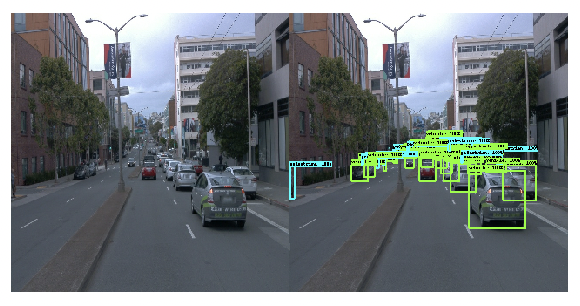


To make sure the training pipeline was setup properly, I decided to greatly restrict the training dataset to just one .tfrecord file (20 images). If everything was ok, the model should overfit quickly to this reduced dataset, and it did. So my conclusion was that 200 training steps (which is, using a batch size of 8, not even an entire epoch over the training set) was utterly insufficient. I decided to crank up to 2000 training steps. Finally, boxes started to be predicted, and that was a sign of being on the right track.

<h3>Improving on the initial model</h3><br>
    The first idea that came into my mind was to improve the dataset augmentation by adding more random transformations. Nevertheless, I found out that maintaining the same 2000 steps of training, the loss was actually greater than before, although the model seemed to be overfitting less:

Training loss with augmentations (less overfitting, but worse results after 2000 steps):
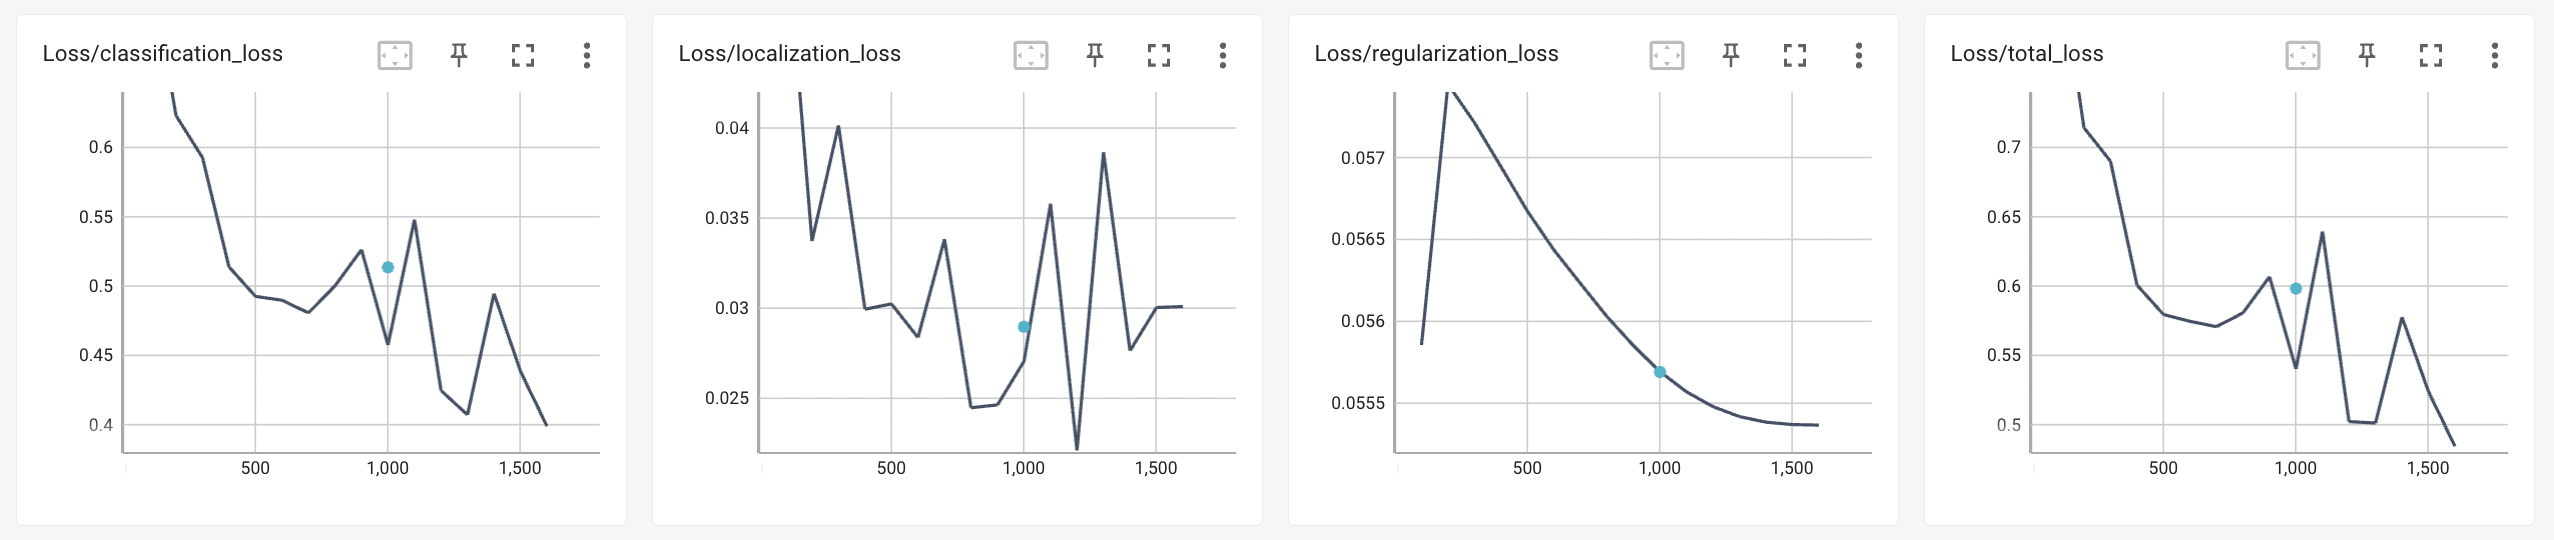

My take on this is that adding this variability to the dataset will actually improve performance on the test set, but at the expense of requiring longer train times. Given the constraints on time and resources, I decided to actually simplify the augmentations and leave only the random horizontal flip, and tune the <b>learning rate cosine decay</b> parameters to better fit the 2000 steps. Even though the gap between train and test loss was greater (sign of overfitting), with that I got reasonable performance.

Training loss with less augmentations and tuned decay cosine rate (more overfitting but better results @2000 steps):
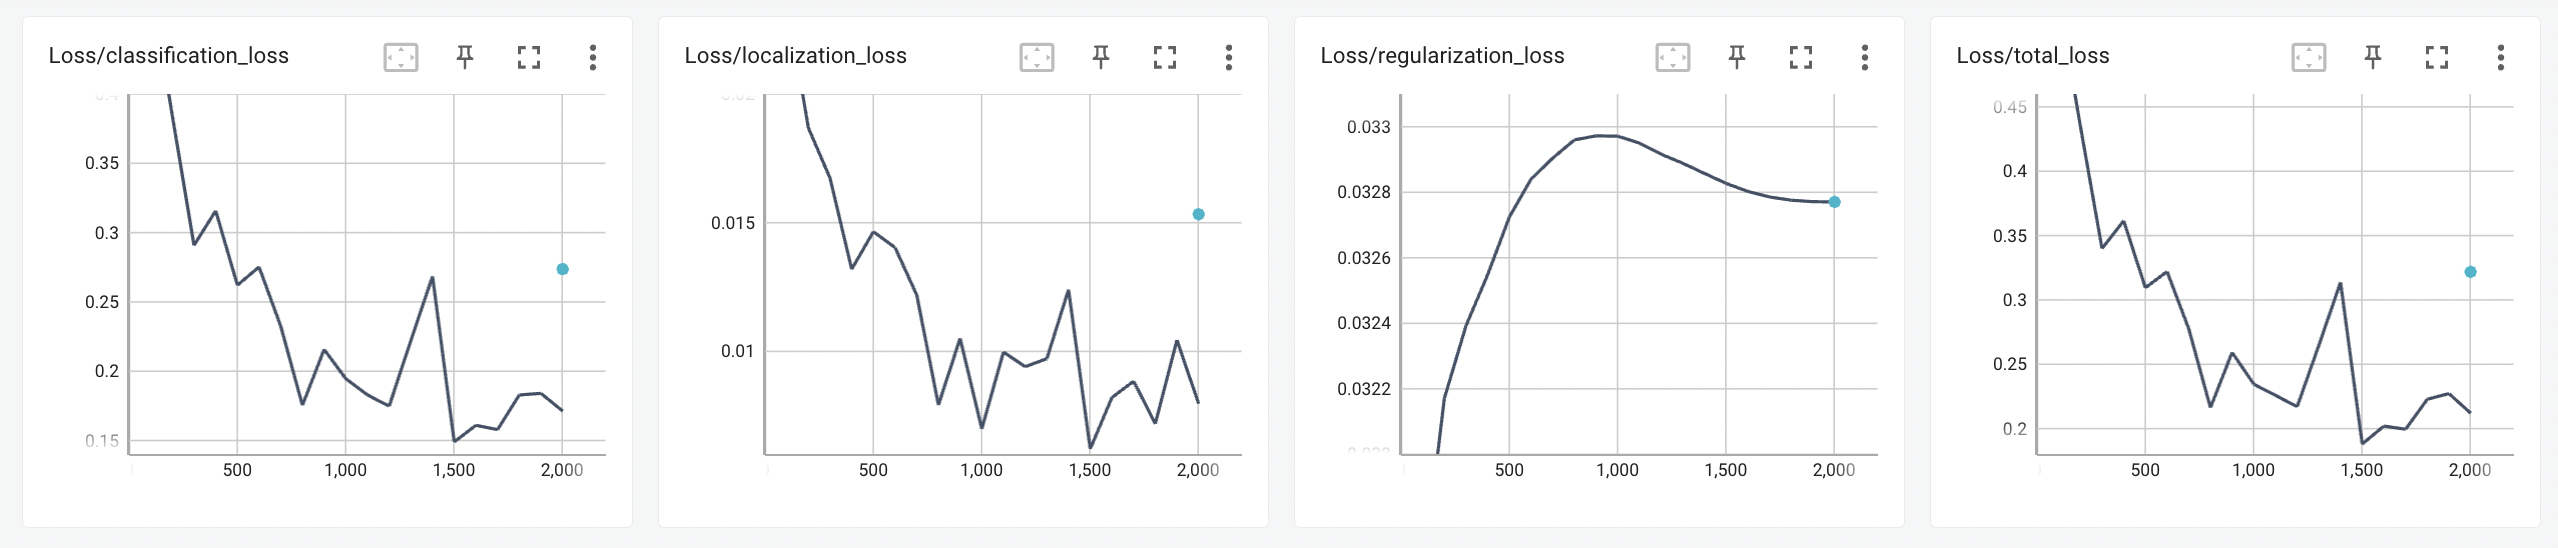

<h3>Further improvements</h3><br>
    
Given sufficient time and resources (each training run took ~2h -even a minimum training run with very little data took a minimum of 20 minutes- so time and associated economic cost was a very great constraint here), there is a huge hyperparameter surface to explore, including different augmentation schemes. A few things that would be worth trying tweaking: <br><br>

<lu>
    <li>Optimizer (Adam, SGD, RMSProp...)</li>
    <li>Learning rate schedule</li>
    <li>Regularization</li>
    <li>Batch normalization parameters</li>
    <li>Aspect ratios of anchors</li>
    <li>Non max suppressor parameters</li>
    <li>Augmentations</li>
    <li>...</li>
</lu>
    
<h3>Testing other models</h3><br>    
    
After downloading the pretrained models and corresponding pipeline.config files, I chose the <b>SSD MobileNet V2 FPNLite 640x640</b> (a smaller model), and the <b>Faster R-CNN ResNet152 V1 640x640</b> (a bigger model). The train times differed greatly, getting the following results on the test set:

Tuned EfficientDet:

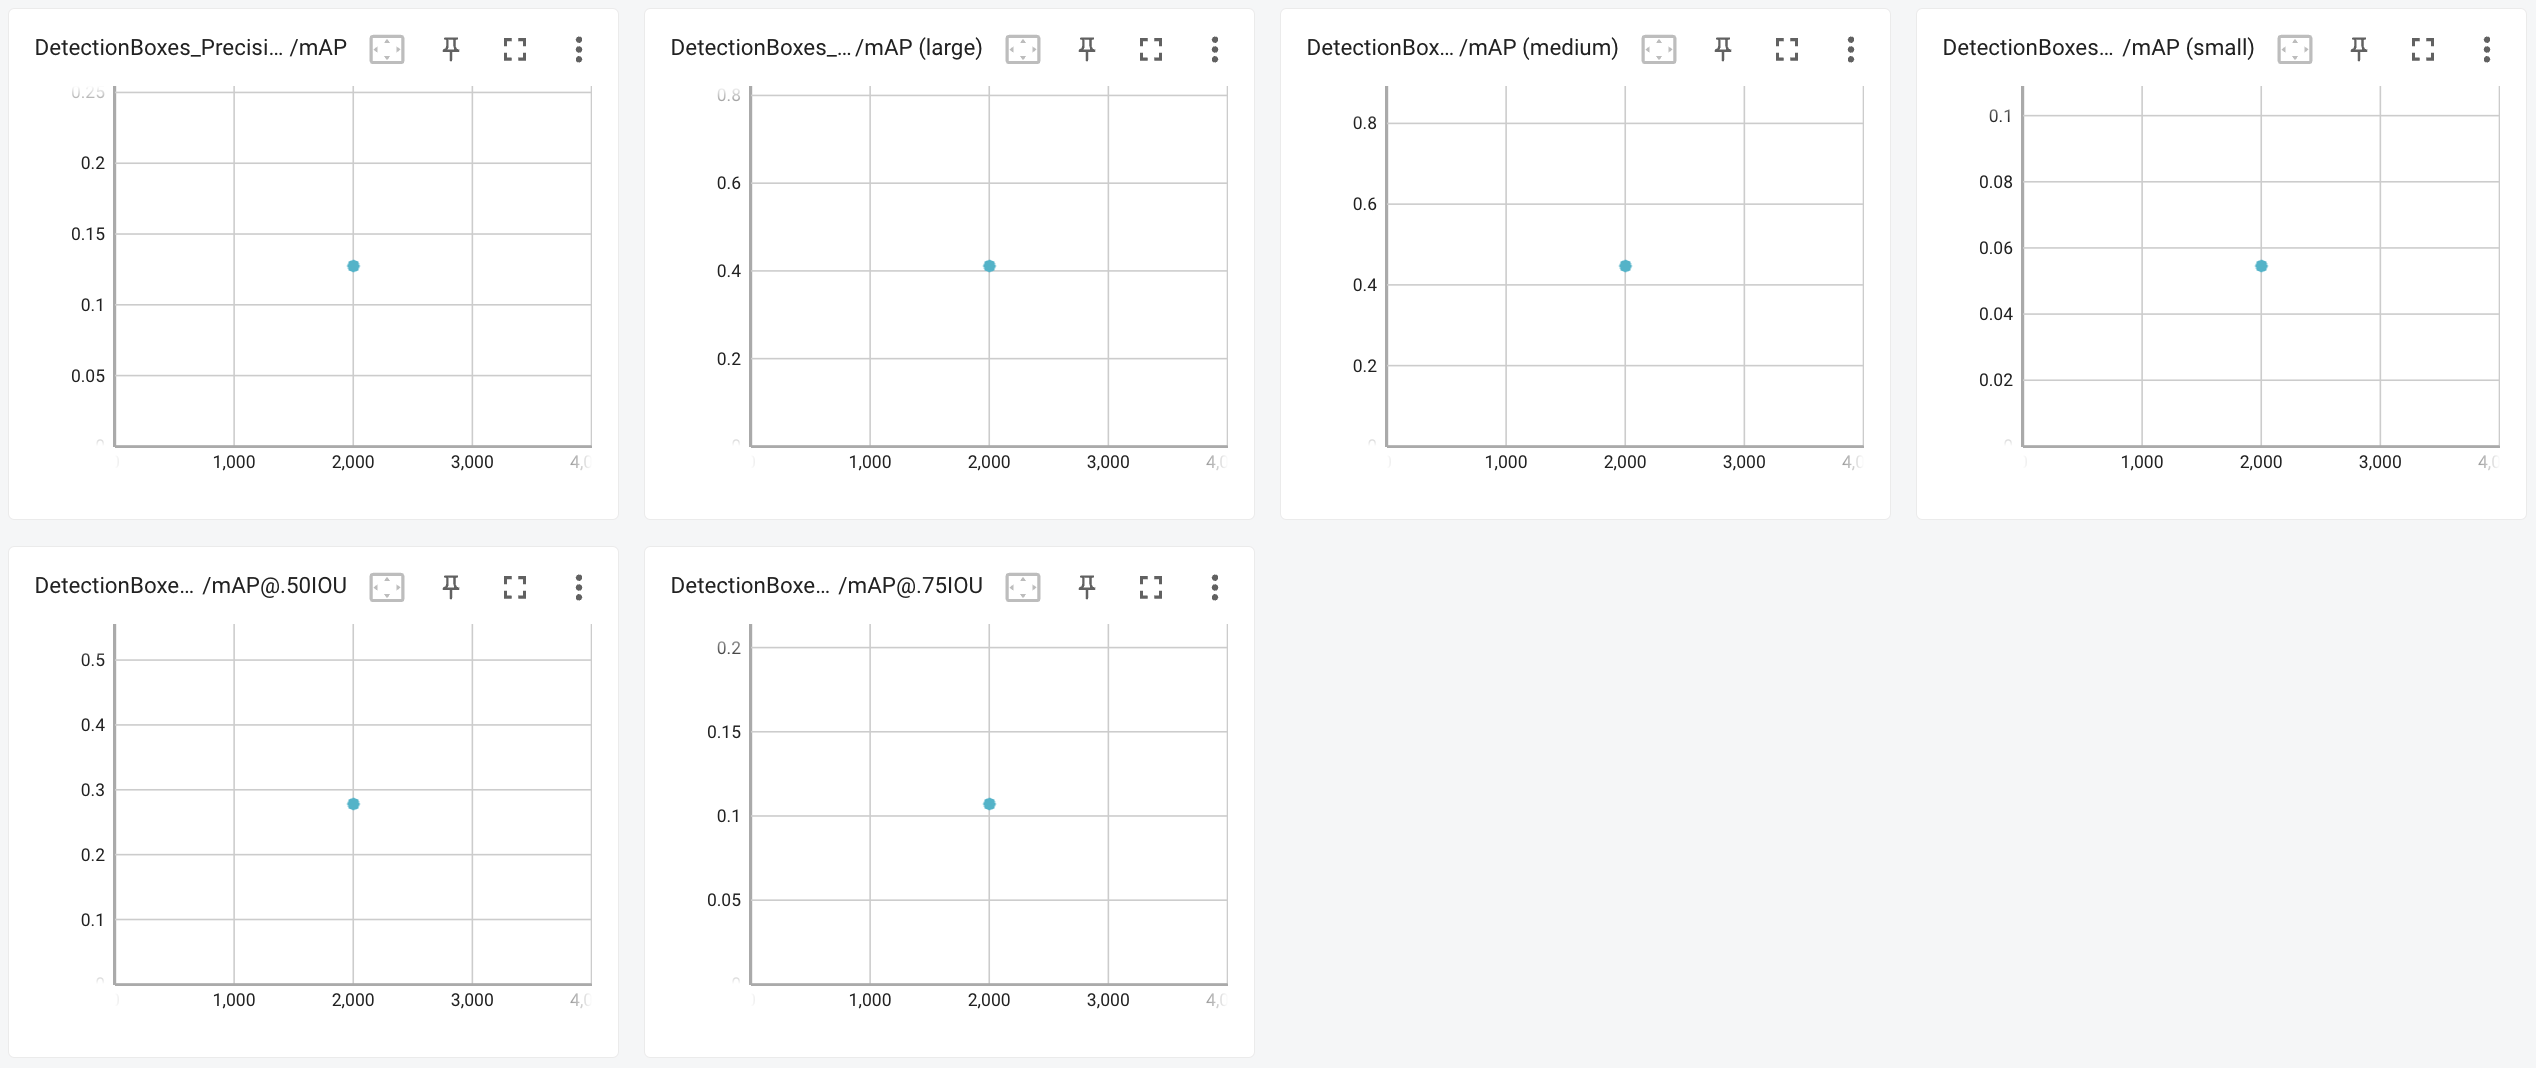

mAP@.50 = 0.2778, mAP@.75 = 0.107, avg = 0.1924

MobileNet:
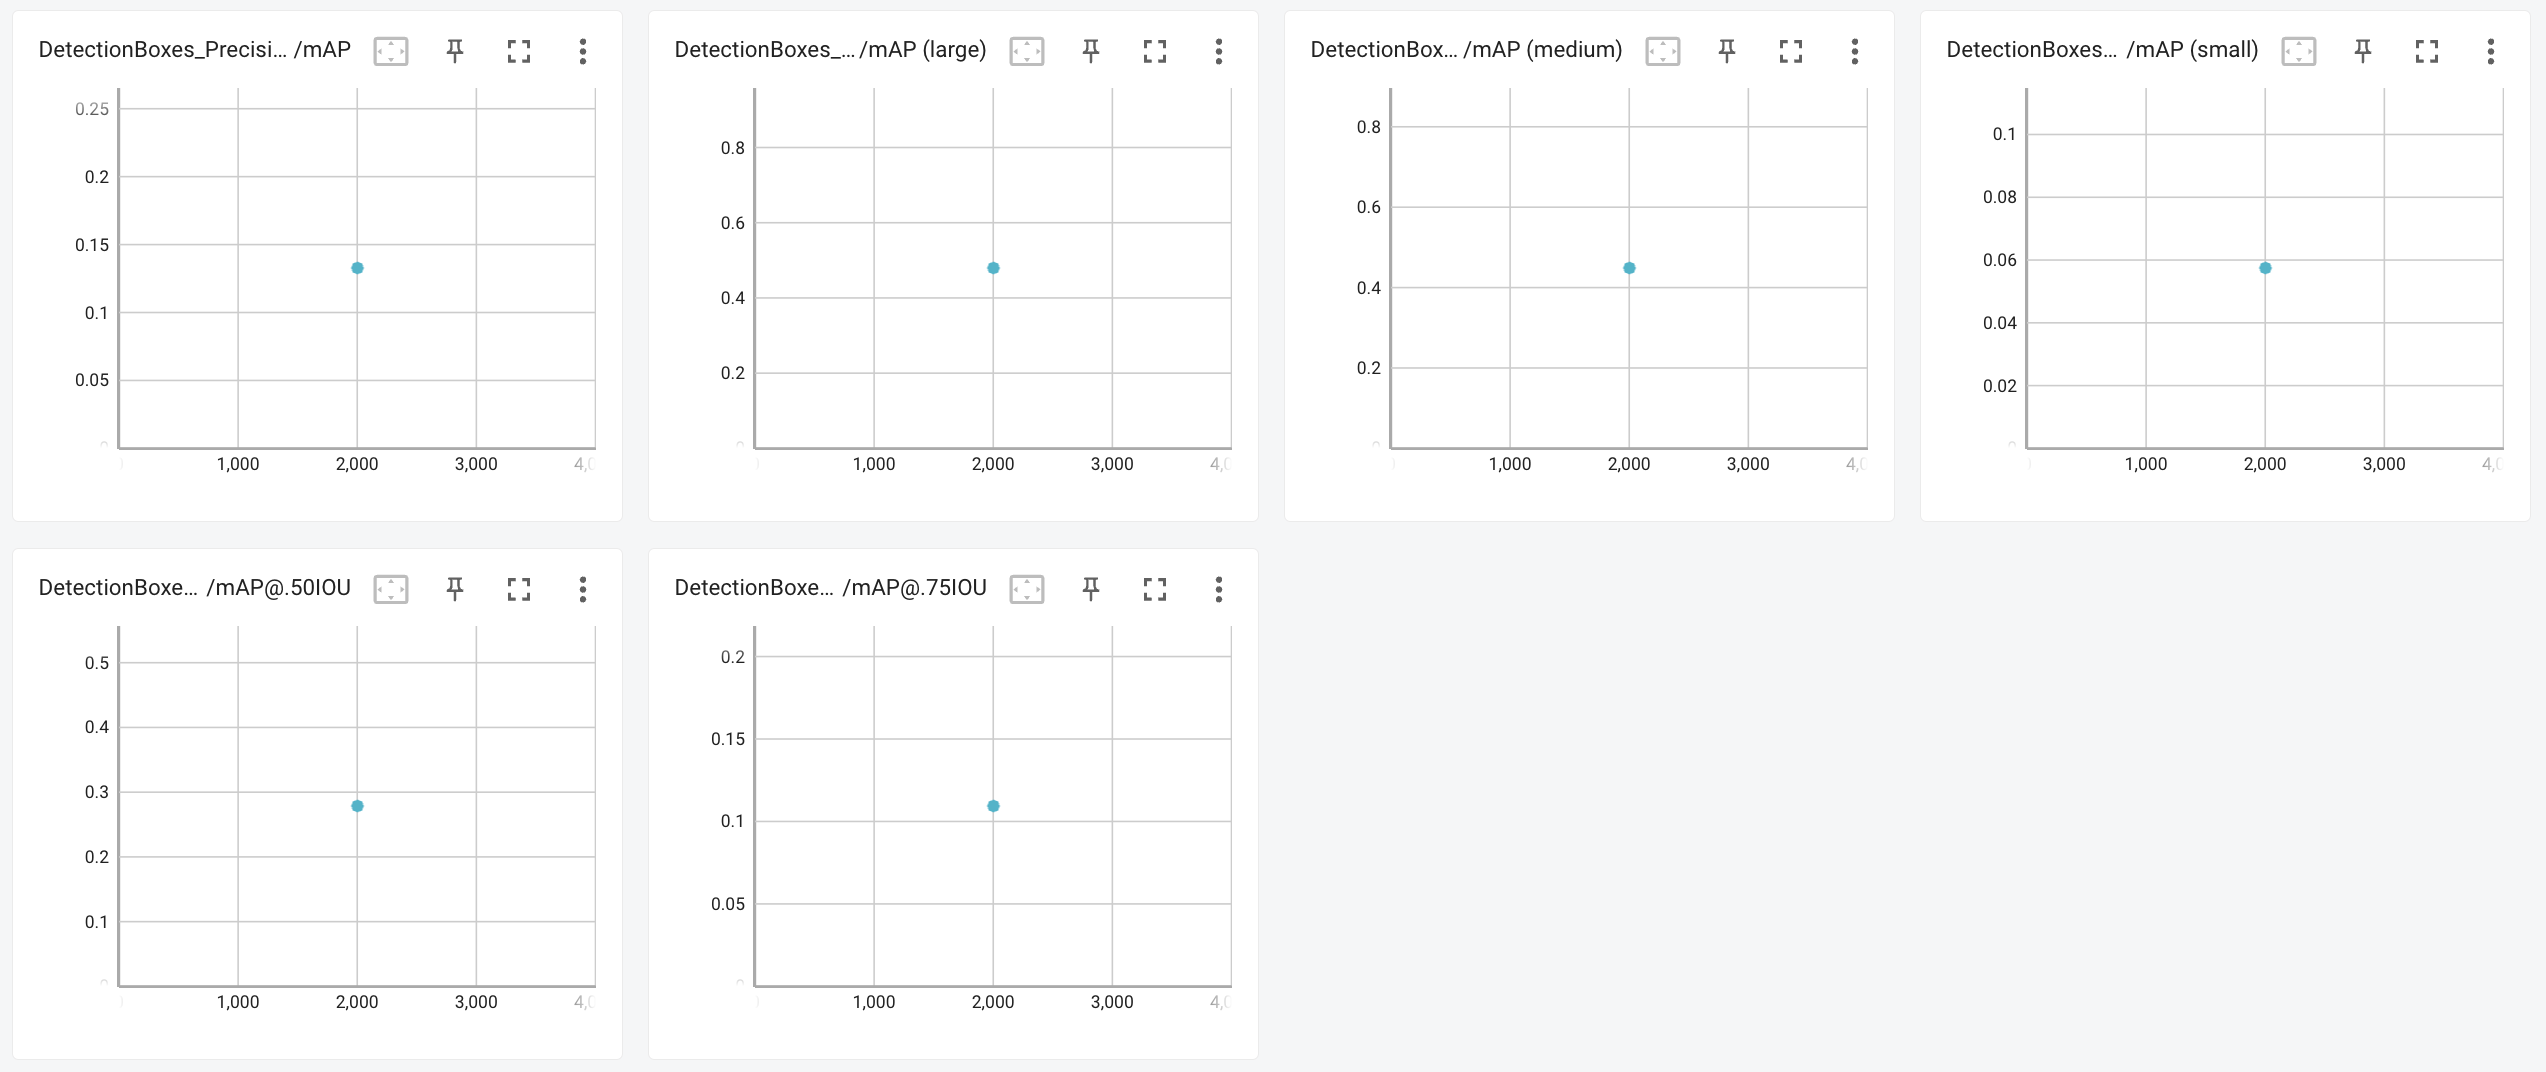

mAP@.50 = 0.2784, mAP@.75 = 0.1093, avg = 0.19385

FasterRCNN:
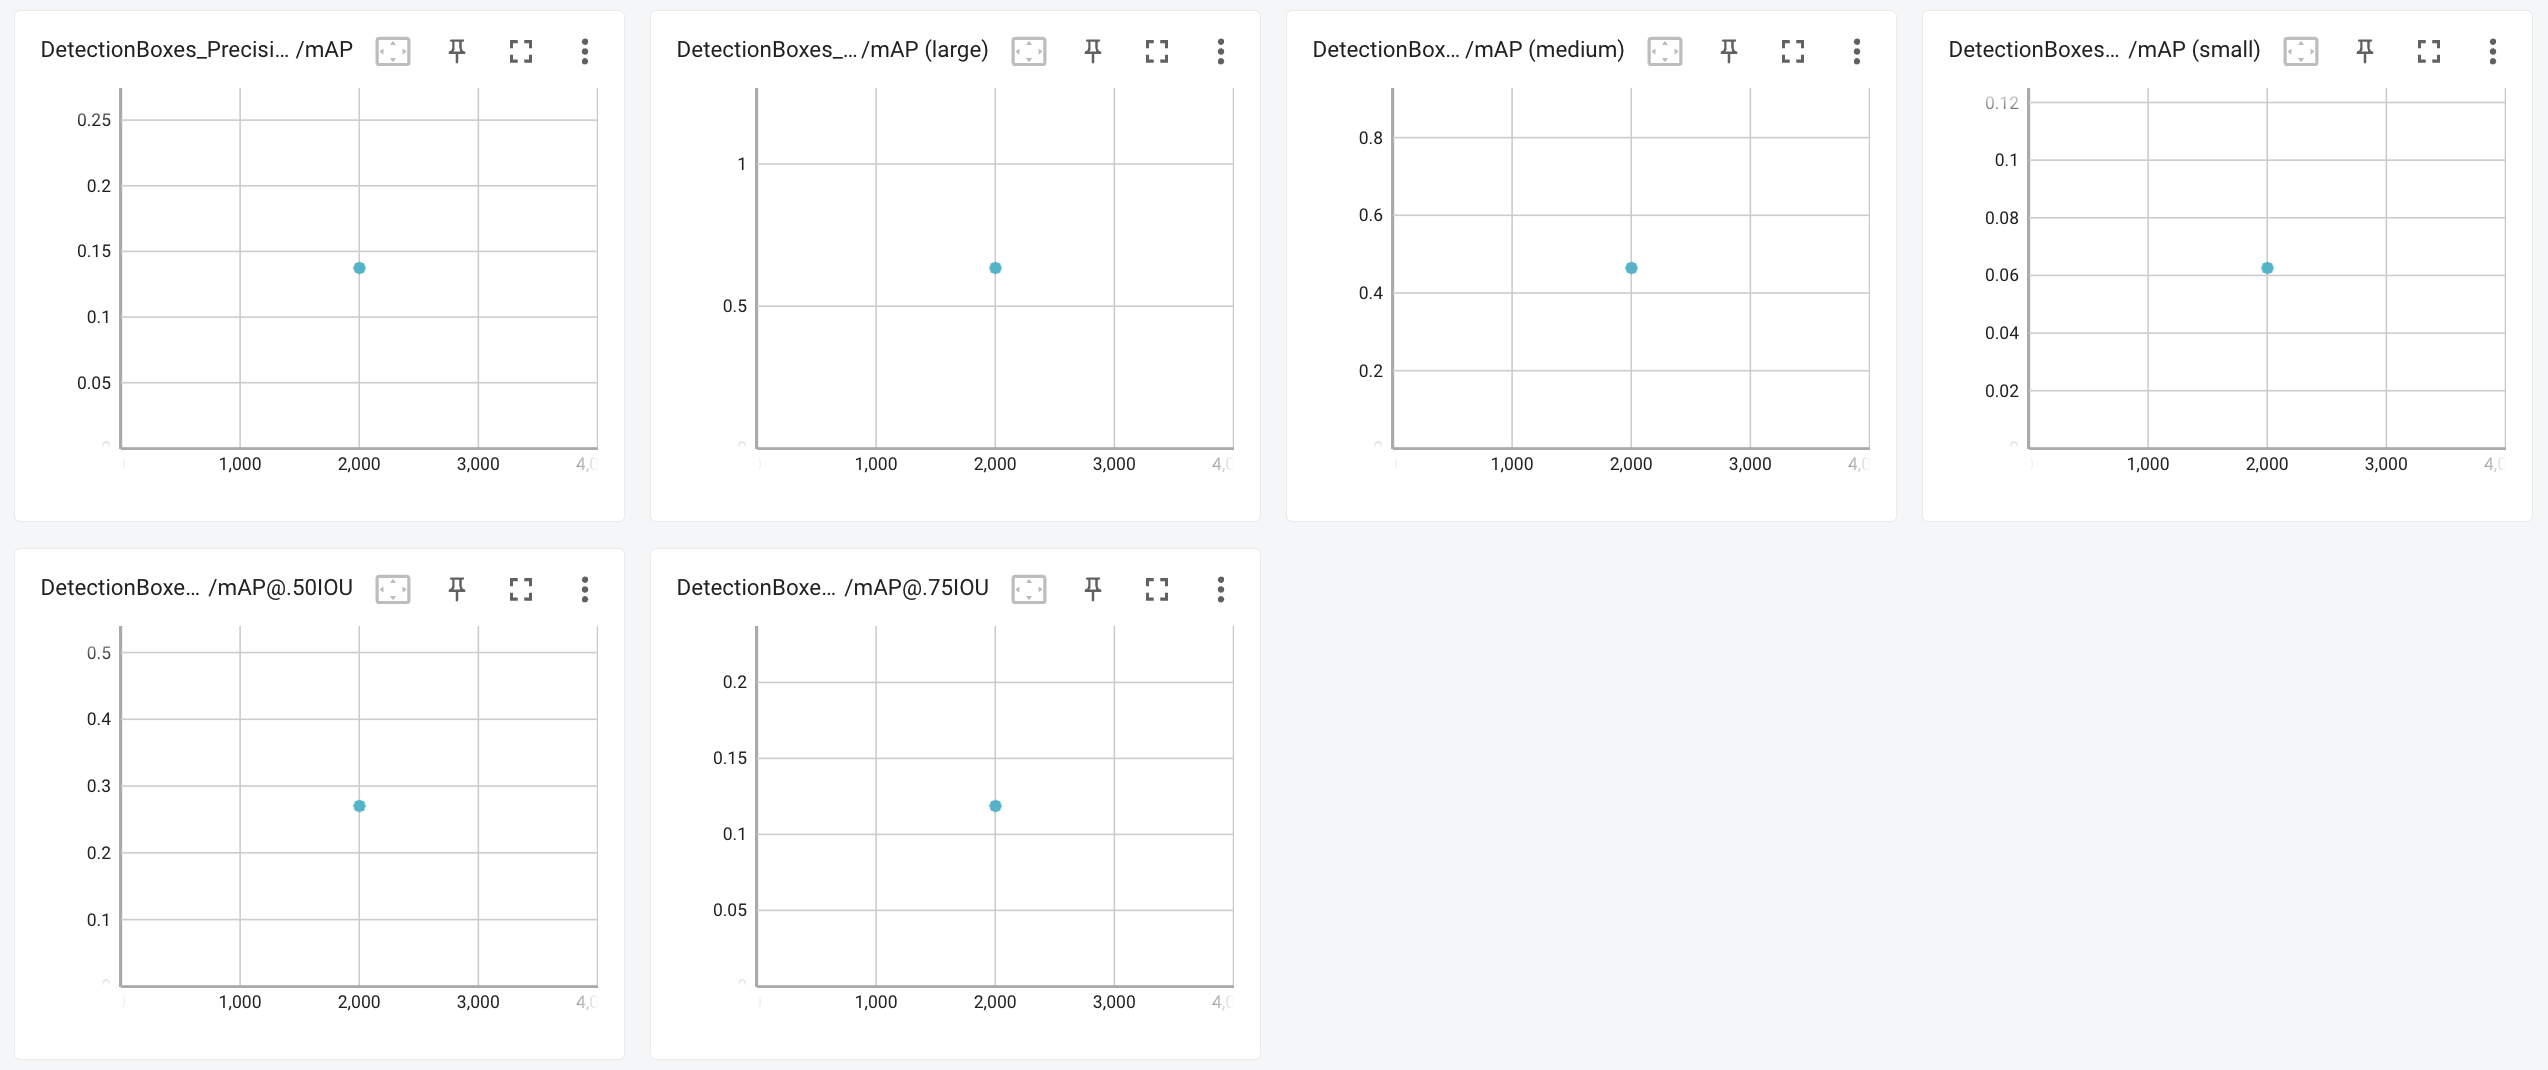

mAP@.50 = 0.2699, mAP@.75 = 0.1186, avg = 0.19425

So performances are very similar, but FasterRCNN does slightly better on the average of mAP@.5 and mAP@.75. I'm going to use FasterRCNN. It is worth noting that, while performance is better, it is important to consider other factors, as training time, model size a inference time. Should these be taken into account, FasterRCNN might not be the best option (the model took ~11h to train, and it's ~10X bigger than the MobileNet model). That said, I'm going to proceed to part II and generate the prediction video with this model.